# EDA

## 0. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
import xgboost as xgb
import lightgbm as lgb
import gc
import os
import random

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# set all random seeds for reproducibility
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [61]:
data_folder = 'ieee-fraud-detection-data/'

train_identity = pd.read_csv(f'{data_folder}train_identity.csv')
train_transaction = pd.read_csv(f'{data_folder}train_transaction.csv')

In [62]:
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.


In [63]:
del train_identity, train_transaction

In [64]:
# replace - to _ in column names to keep consistent naming
train.columns = [col.replace('-', '_') for col in train.columns]

## 1. Helper functions

In [65]:
def drop_correlated_features(
    df, 
    threshold=0.9, 
    method="pearson",
    verbose=True
):
    """
    Removes highly correlated features from a dataframe.

    Parameters:
        df (pd.DataFrame): Input dataframe
        threshold (float): Correlation threshold for dropping features
        method (str): Correlation method ('pearson', 'spearman', 'kendall')
        verbose (bool): Print removed columns information

    Returns:
        pd.DataFrame: DataFrame with reduced features
        set: Dropped columns
    """

    # Compute correlation matrix
    corr_matrix = df.corr(method=method).abs()

    # Upper triangle of correlation matrix (to avoid duplicate pairs)
    upper_tri = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    upper_corr = corr_matrix.where(upper_tri)

    # Features to drop
    to_drop = set()

    for col in upper_corr.columns:
        # If any correlation above threshold, drop this column
        if any(upper_corr[col] > threshold):
            to_drop.add(col)

    # Optionally print what was removed
    if verbose:
        print(f"Correlation threshold: {threshold}")
        print(f"Dropping {len(to_drop)} correlated features:")
        for c in to_drop:
            print(" •", c)

    # Return reduced dataframe
    reduced_df = df.drop(columns=to_drop)
    return reduced_df, to_drop

## 2. Target Variable Analysis


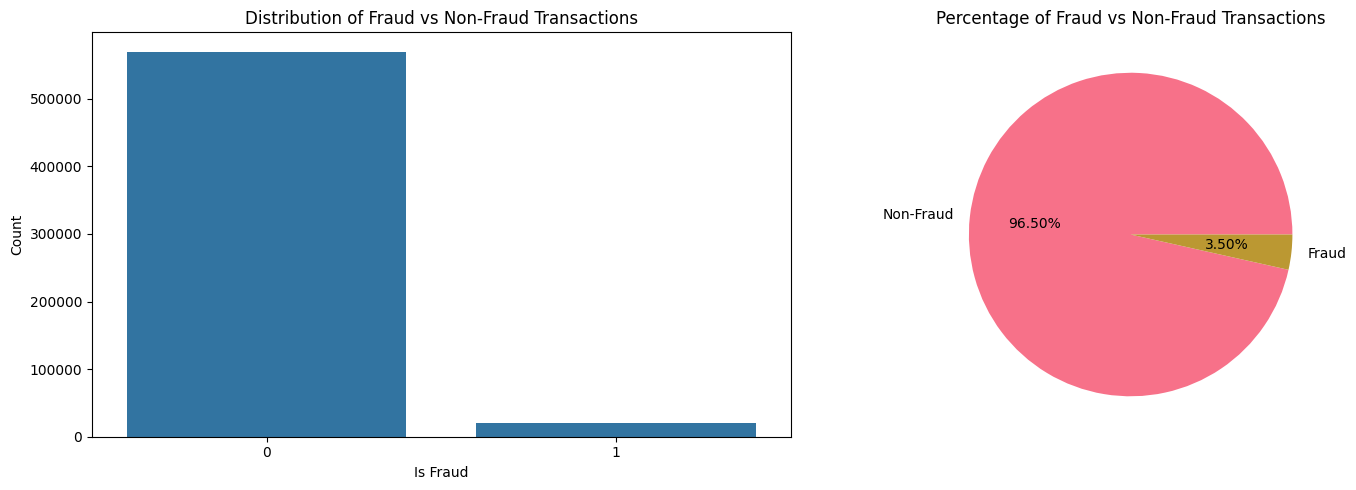


Detailed Statistics:
Total Transactions: 590,540
Fraud Transactions: 20,663
Non-Fraud Transactions: 569,877

Fraud Rate: 3.50%


In [6]:
# Calculate fraud distribution
fraud_dist = train['isFraud'].value_counts()
fraud_pct = train['isFraud'].value_counts(normalize=True) * 100

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Bar chart
sns.barplot(x=fraud_dist.index, y=fraud_dist.values, ax=ax1)
ax1.set_title('Distribution of Fraud vs Non-Fraud Transactions')
ax1.set_xlabel('Is Fraud')
ax1.set_ylabel('Count')

# Plot 2: Pie chart
colors = sns.color_palette('husl')[:2]
ax2.pie(fraud_pct, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%', colors=colors)
ax2.set_title('Percentage of Fraud vs Non-Fraud Transactions')

plt.tight_layout()
plt.show()

print("\nDetailed Statistics:")
print(f"Total Transactions: {len(train):,}")
print(f"Fraud Transactions: {fraud_dist[1]:,}")
print(f"Non-Fraud Transactions: {fraud_dist[0]:,}")
print(f"\nFraud Rate: {fraud_pct[1]:.2f}%")

## 3. Missing Values

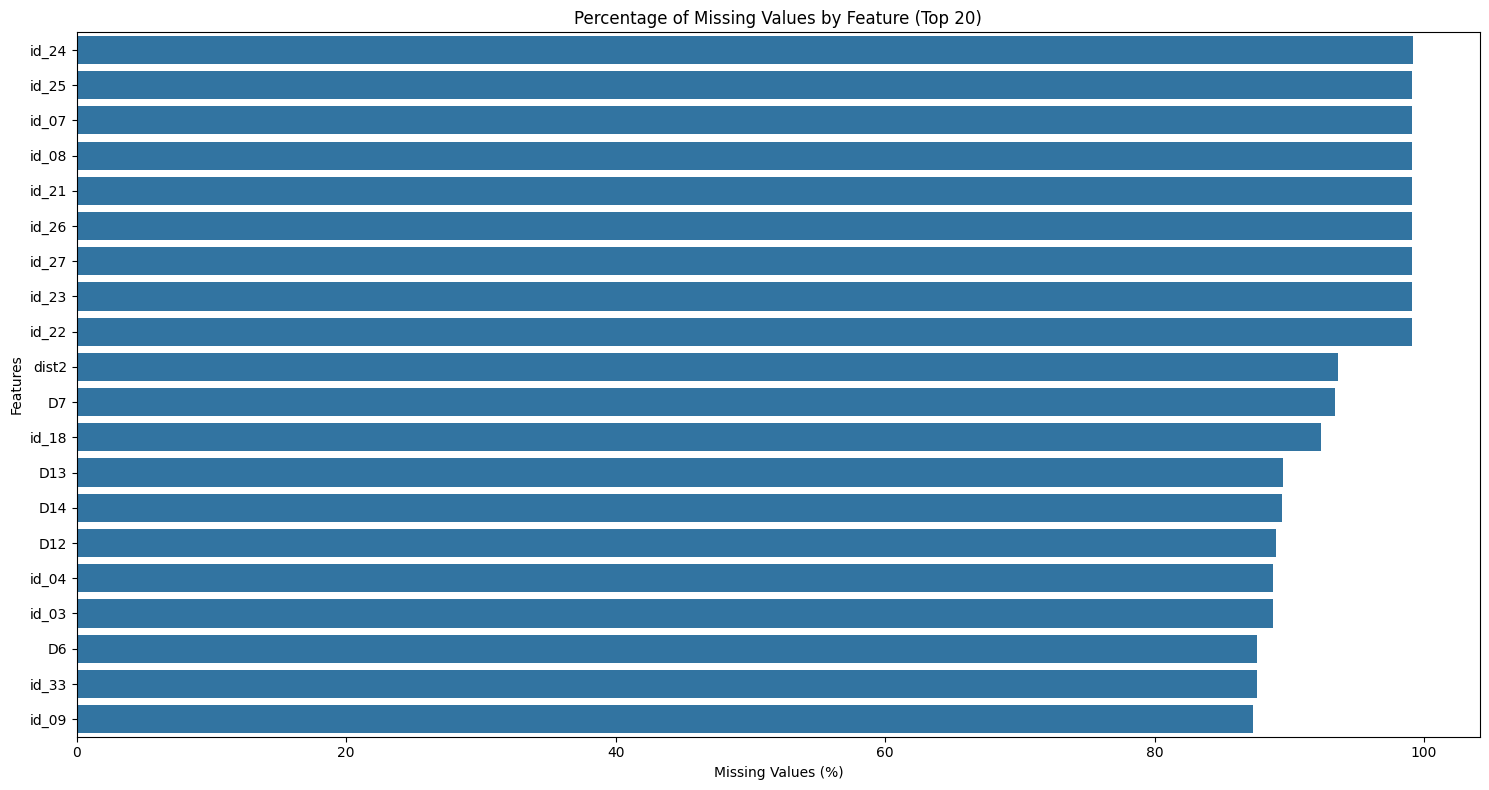


Features with more than 50% missing values: (total: 214)
id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
id_26            99.125715
id_27            99.124699
id_23            99.124699
id_22            99.124699
dist2            93.628374
D7               93.409930
id_18            92.360721
D13              89.509263
D14              89.469469
D12              89.041047
id_04            88.768923
id_03            88.768923
D6               87.606767
id_33            87.589494
id_09            87.312290
D8               87.312290
id_10            87.312290
D9               87.312290
id_30            86.865411
id_32            86.861855
id_34            86.824771
id_14            86.445626
V138             86.123717
V139             86.123717
V148             86.123717
V154             86.123717
V162             86.123717
V141             86.123717
V157             86.123717
V146             86.1237

In [7]:
# Calculate missing values percentage for each column
missing_values = (train.isnull().sum() / len(train) * 100).sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]  # Only keep columns with missing values

# Plot only the top 20 features with the highest missingness
top_missing = missing_values.head(20)
plt.figure(figsize=(15, 8))
sns.barplot(x=top_missing.values, y=top_missing.index)
plt.title('Percentage of Missing Values by Feature (Top 20)')
plt.xlabel('Missing Values (%)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Display features with high missingness (>50%)
print(f"\nFeatures with more than 50% missing values: (total: {len(missing_values[missing_values > 50])})")
print(missing_values[missing_values > 50].to_string())

# Display features with moderate missingness (20-50%)
print(f"\nFeatures with 20-50% missing values: (total: {len(missing_values[(missing_values > 20) & (missing_values <= 50)])})")
print(missing_values[(missing_values > 20) & (missing_values <= 50)].to_string())

We see a lot of features with high percentage of missing values. That beeing said, we dont drop all those features, because missingness of a feature might be an important indicator of fraud. we drop only > 99%

In [108]:
#drop columns >99%
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
train = train.drop(many_null_cols, axis='columns')
del many_null_cols

## 4. TransactionDT (Time)

In [67]:
# Convert TransactionDT to days
train['TransactionDay'] = train['TransactionDT'] / (24*60*60)

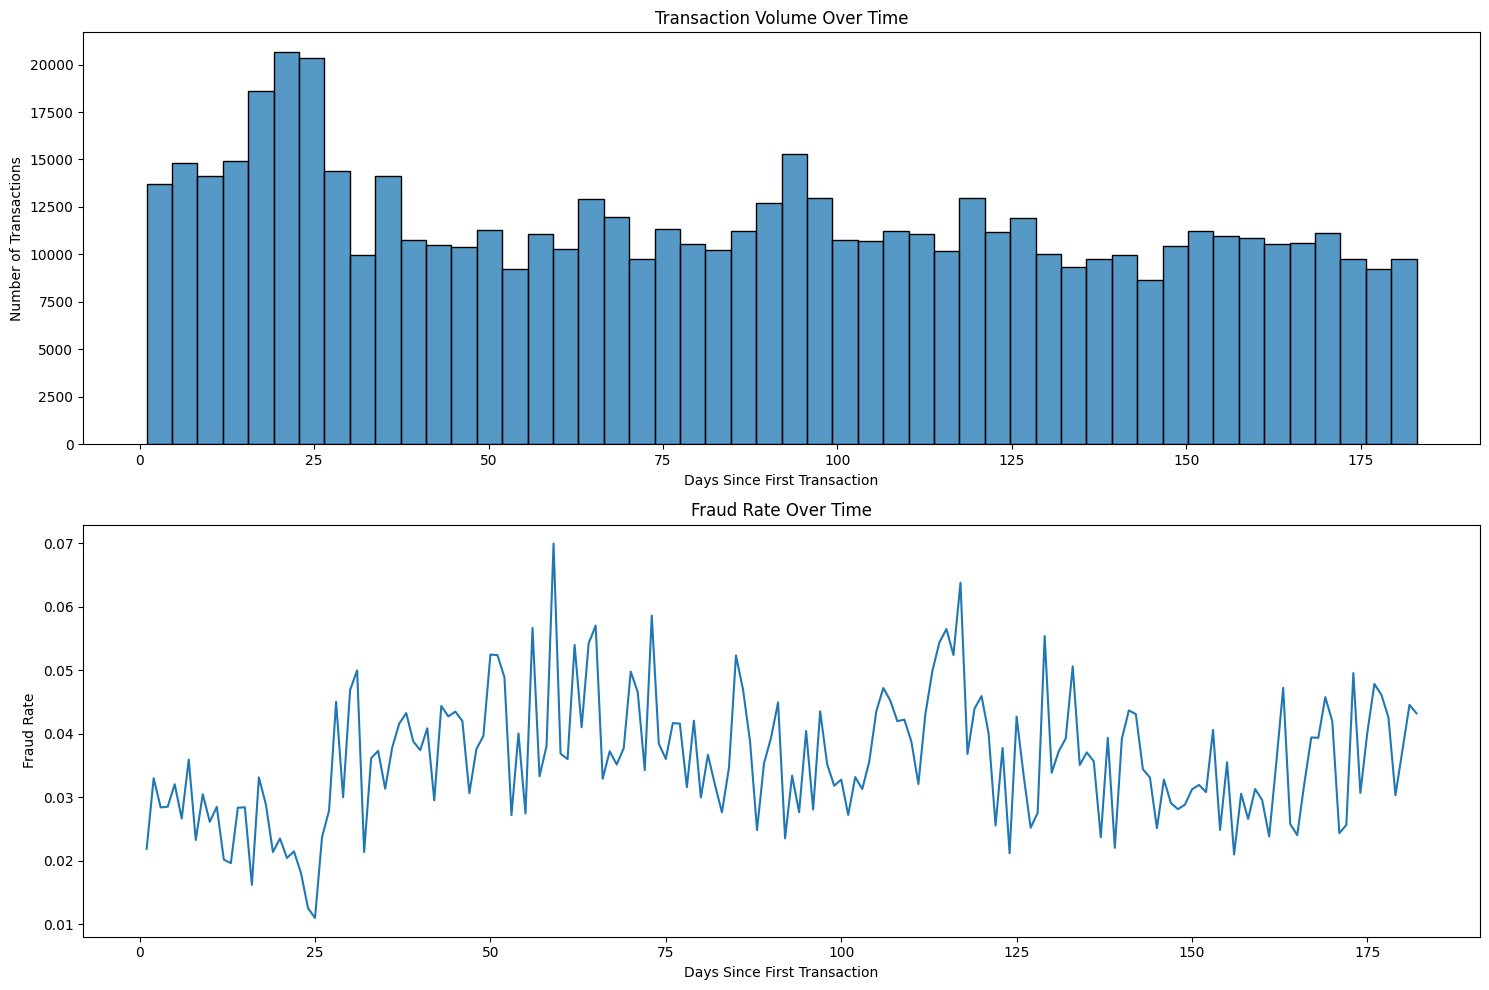


Time-based Statistics:
Total time span: 182.0 days
Average daily transactions: 3244.7

Fraud Rate Statistics:
Minimum daily fraud rate: 1.097%
Maximum daily fraud rate: 6.994%
Average daily fraud rate: 3.605%


In [10]:
# Create time-based visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Transaction volume over time
plt.subplot(2, 1, 1)
sns.histplot(data=train, x='TransactionDay', bins=50)
plt.title('Transaction Volume Over Time')
plt.xlabel('Days Since First Transaction')
plt.ylabel('Number of Transactions')

# Plot 2: Fraud rate over time
plt.subplot(2, 1, 2)
fraud_rate = train.groupby(train['TransactionDay'].astype(int))['isFraud'].mean()
plt.plot(fraud_rate.index, fraud_rate.values)
plt.title('Fraud Rate Over Time')
plt.xlabel('Days Since First Transaction')
plt.ylabel('Fraud Rate')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nTime-based Statistics:")
print(f"Total time span: {train['TransactionDay'].max()-train['TransactionDay'].min():.1f} days")
print(f"Average daily transactions: {len(train)/len(fraud_rate):.1f}")
print("\nFraud Rate Statistics:")
print(f"Minimum daily fraud rate: {fraud_rate.min():.3%}")
print(f"Maximum daily fraud rate: {fraud_rate.max():.3%}")
print(f"Average daily fraud rate: {fraud_rate.mean():.3%}")

In [68]:
# create 'day of week' categorical feature
train['day_of_week'] = train['TransactionDT']//3600//24 % 7

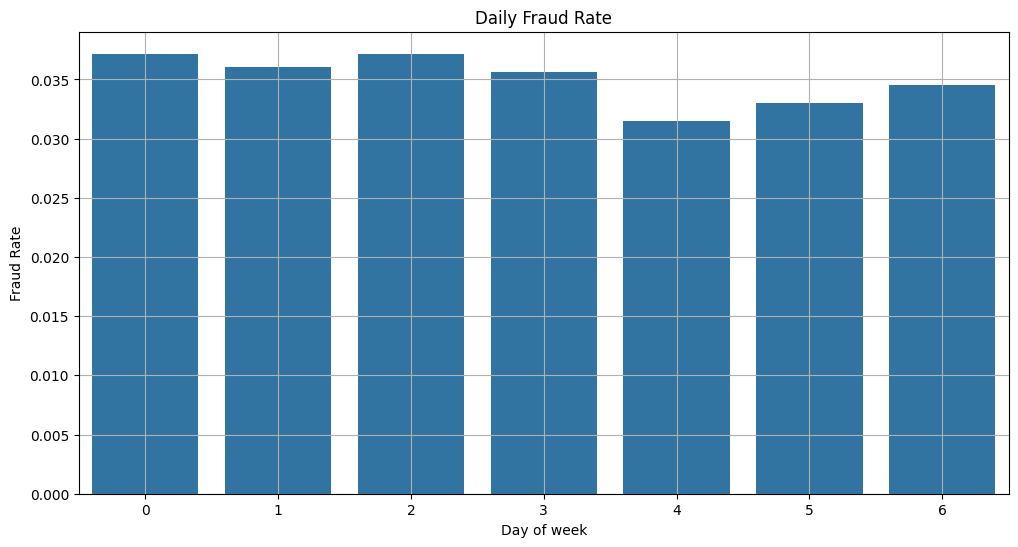


Daily Fraud Rate Statistics:
Minimum daily fraud rate: 3.145%
Maximum daily fraud rate: 3.717%
Average daily fraud rate: 3.500%


In [12]:
# plot daily fraud
daily_fraud = train.groupby('day_of_week')['isFraud'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=daily_fraud.index, y=daily_fraud.values)
plt.title('Daily Fraud Rate')
plt.xlabel('Day of week')
plt.ylabel('Fraud Rate')
plt.xticks(range(0, 7))
plt.grid()
plt.show()

print("\nDaily Fraud Rate Statistics:")
print(f"Minimum daily fraud rate: {daily_fraud.min():.3%}")
print(f"Maximum daily fraud rate: {daily_fraud.max():.3%}")
print(f"Average daily fraud rate: {daily_fraud.mean():.3%}")

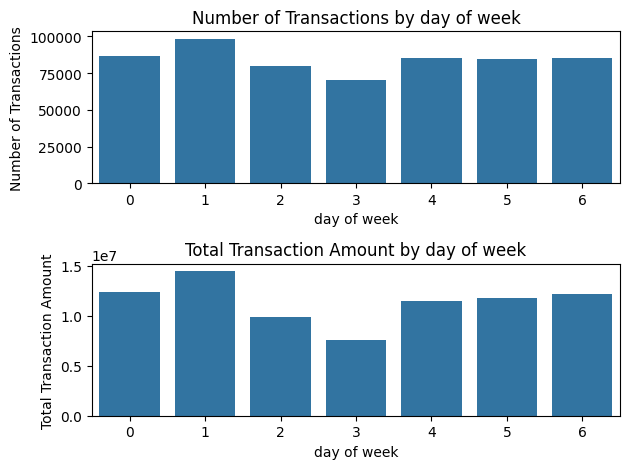


dayly Transaction Statistics:
day with minimum transactions: 3 (70223 transactions)
day with maximum transactions: 1 (98502 transactions)
day with minimum transaction amount: 3 ($7,554,714.29)
day with maximum transaction amount: 1 ($14,470,095.08)


In [13]:
#plot amount of transactions (number of transactions and total amount) based on day
plt.subplot(2,1,1)
dayly_transactions = train.groupby('day_of_week').size()
sns.barplot(x=dayly_transactions.index, y=dayly_transactions.values)
plt.title('Number of Transactions by day of week')
plt.xlabel('day of week')
plt.ylabel('Number of Transactions')

plt.subplot(2,1,2)
dayly_amount = train.groupby('day_of_week')['TransactionAmt'].sum()
sns.barplot(x=dayly_amount.index, y=dayly_amount.values)
plt.title('Total Transaction Amount by day of week')
plt.xlabel('day of week')
plt.ylabel('Total Transaction Amount')

plt.tight_layout()
plt.show()

print("\ndayly Transaction Statistics:")
print(f"day with minimum transactions: {dayly_transactions.idxmin()} ({dayly_transactions.min()} transactions)")
print(f"day with maximum transactions: {dayly_transactions.idxmax()} ({dayly_transactions.max()} transactions)")
print(f"day with minimum transaction amount: {dayly_amount.idxmin()} (${dayly_amount.min():,.2f})")
print(f"day with maximum transaction amount: {dayly_amount.idxmax()} (${dayly_amount.max():,.2f})")


In [69]:
# create 'hour of day' categorical feature
train['hour_of_day'] = train['TransactionDT']//3600 % 24

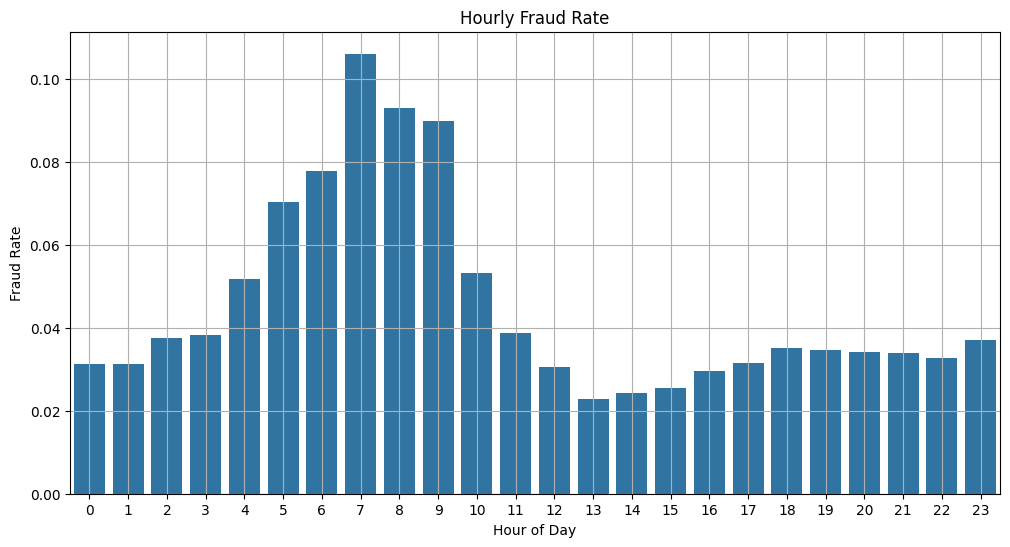


Hourly Fraud Rate Statistics:
Minimum hourly fraud rate: 2.289%
Maximum hourly fraud rate: 10.610%
Average hourly fraud rate: 4.548%


In [15]:
# plot hourly fraud
hourly_fraud = train.groupby('hour_of_day')['isFraud'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_fraud.index, y=hourly_fraud.values)
plt.title('Hourly Fraud Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate')
plt.xticks(range(0, 24))
plt.grid()
plt.show()

print("\nHourly Fraud Rate Statistics:")
print(f"Minimum hourly fraud rate: {hourly_fraud.min():.3%}")
print(f"Maximum hourly fraud rate: {hourly_fraud.max():.3%}")
print(f"Average hourly fraud rate: {hourly_fraud.mean():.3%}")

There is a possible relationship shown between hour of transaction and fraud rate.

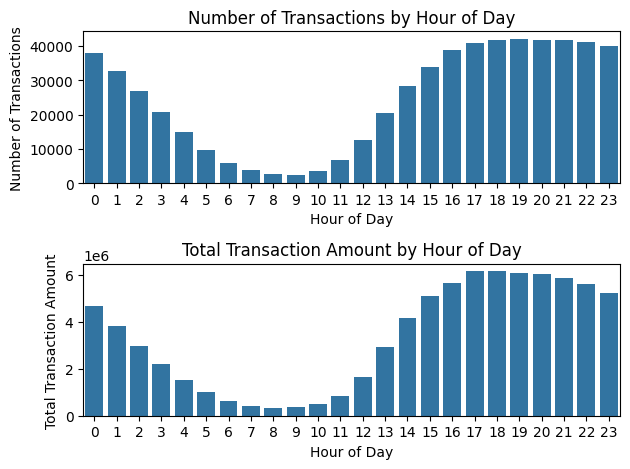


Hourly Transaction Statistics:
Hour with minimum transactions: 9 (2479 transactions)
Hour with maximum transactions: 19 (42115 transactions)
Hour with minimum transaction amount: 8 ($325,013.26)
Hour with maximum transaction amount: 17 ($6,150,905.44)


In [16]:
#plot amount of transactions (number of transactions and total amount) based on hour
plt.subplot(2,1,1)
hourly_transactions = train.groupby('hour_of_day').size()
sns.barplot(x=hourly_transactions.index, y=hourly_transactions.values)
plt.title('Number of Transactions by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')

plt.subplot(2,1,2)
hourly_amount = train.groupby('hour_of_day')['TransactionAmt'].sum()
sns.barplot(x=hourly_amount.index, y=hourly_amount.values)
plt.title('Total Transaction Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Transaction Amount')

plt.tight_layout()
plt.show()

print("\nHourly Transaction Statistics:")
print(f"Hour with minimum transactions: {hourly_transactions.idxmin()} ({hourly_transactions.min()} transactions)")
print(f"Hour with maximum transactions: {hourly_transactions.idxmax()} ({hourly_transactions.max()} transactions)")
print(f"Hour with minimum transaction amount: {hourly_amount.idxmin()} (${hourly_amount.min():,.2f})")
print(f"Hour with maximum transaction amount: {hourly_amount.idxmax()} (${hourly_amount.max():,.2f})")


## 5. TransactionAMT


In [73]:
# create decimal places columns (since decimal places might indicate currency conversion)
train['DecimalPlaces'] = train['TransactionAmt'].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)

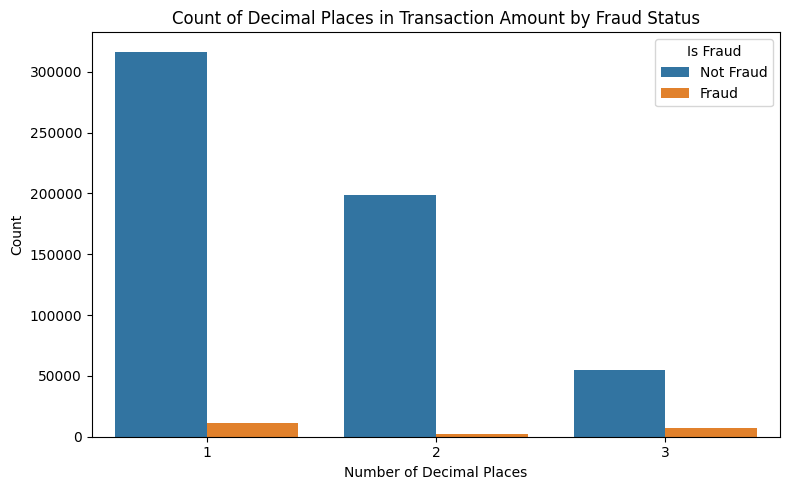

In [35]:
# plot count of decimal places by fraud
plt.figure(figsize=(8, 5))
sns.countplot(data=train, x='DecimalPlaces', hue='isFraud')
plt.title('Count of Decimal Places in Transaction Amount by Fraud Status')
plt.xlabel('Number of Decimal Places')
plt.ylabel('Count')
plt.legend(title='Is Fraud', labels=['Not Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

In [74]:
# create cents column
train["cents"] = ((train["TransactionAmt"] % 1) * 100).round().astype(int)

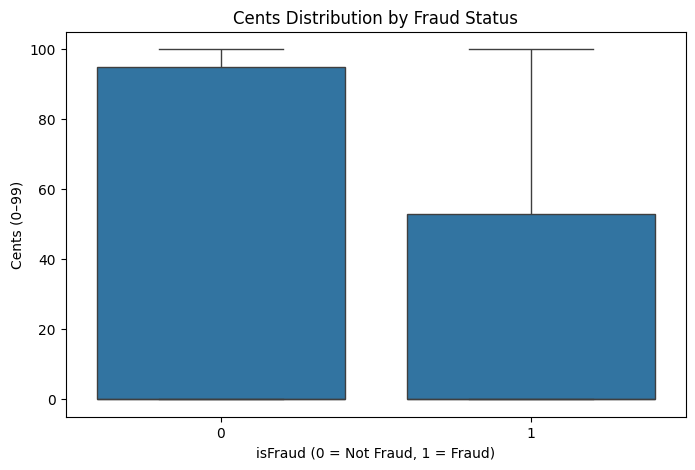

In [38]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=train, x='isFraud', y='cents')
plt.title("Cents Distribution by Fraud Status")
plt.xlabel("isFraud (0 = Not Fraud, 1 = Fraud)")
plt.ylabel("Cents (0–99)")
plt.show()

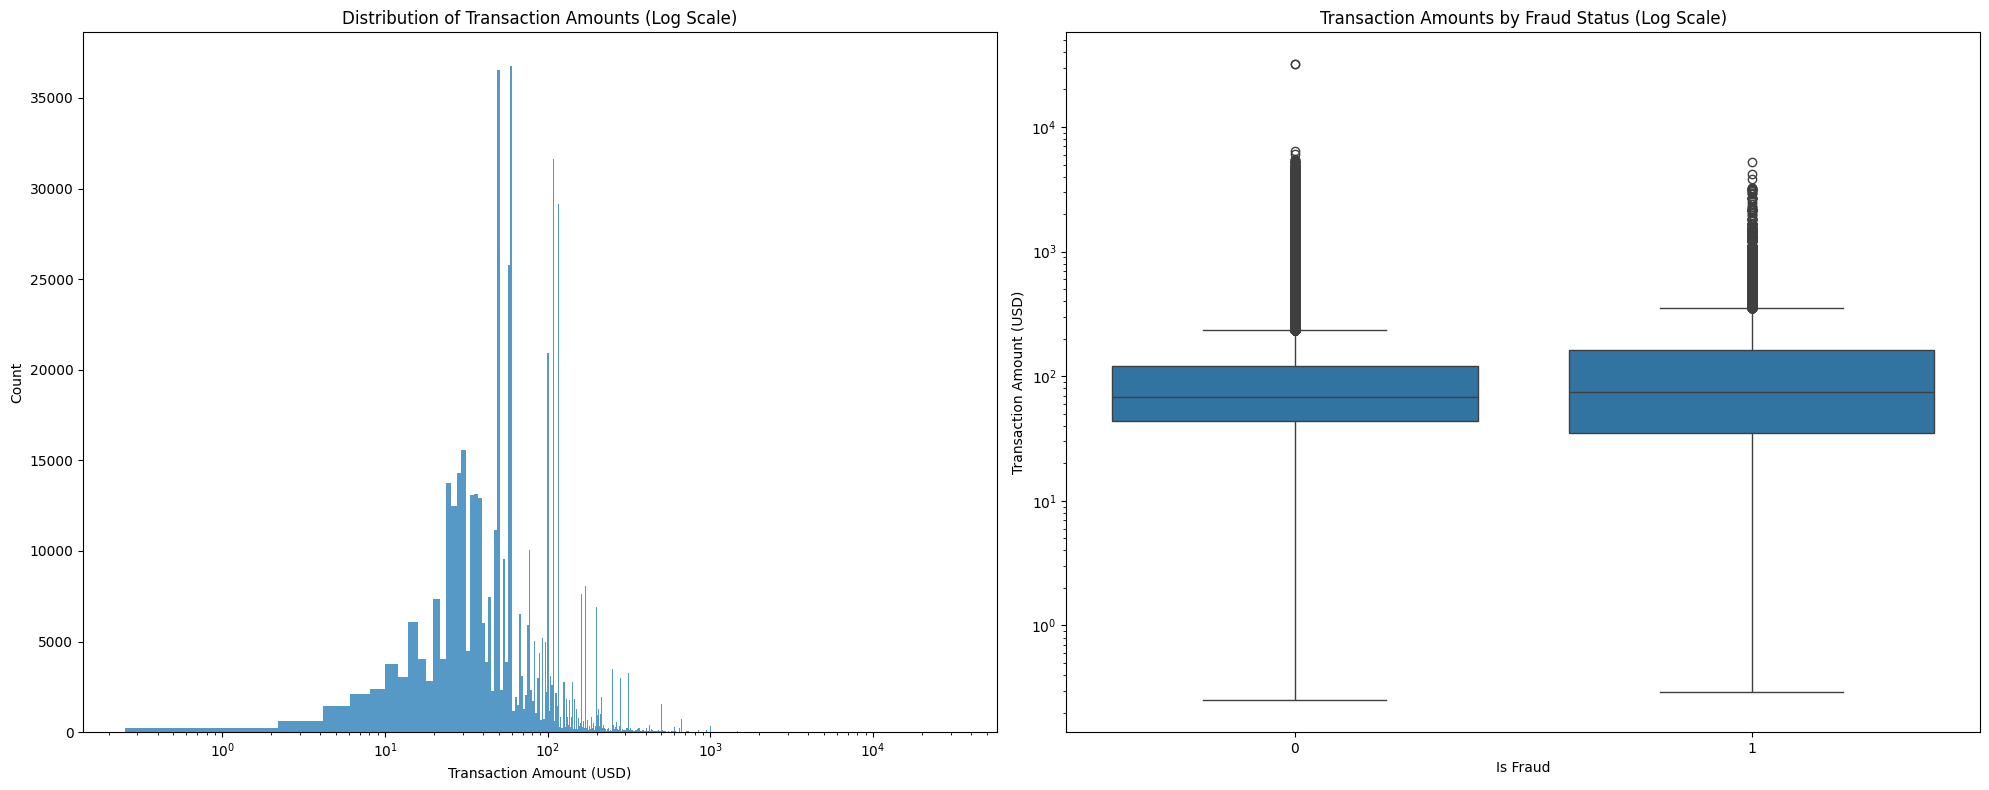

In [39]:
# Create visualizations for TransactionAMT
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Distribution of transaction amounts (log scale)
sns.histplot(data=train, x='TransactionAmt', ax=ax1)
ax1.set_xscale('log')
ax1.set_title('Distribution of Transaction Amounts (Log Scale)')
ax1.set_xlabel('Transaction Amount (USD)')
ax1.set_ylabel('Count')

# Plot 2: Box plot of amounts by fraud status (log scale)
sns.boxplot(data=train, x='isFraud', y='TransactionAmt', ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Transaction Amounts by Fraud Status (Log Scale)')
ax2.set_xlabel('Is Fraud')
ax2.set_ylabel('Transaction Amount (USD)')

plt.tight_layout()
plt.show()

In [40]:
# Print statistics about transaction amounts
print("\nTransaction Amount Statistics:")
print(f"Minimum amount: ${train['TransactionAmt'].min():.2f}")
print(f"Maximum amount: ${train['TransactionAmt'].max():.2f}")
print(f"Mean amount: ${train['TransactionAmt'].mean():.2f}")
print(f"Median amount: ${train['TransactionAmt'].median():.2f}")
# Print quartile values for Transaction Amount
quartiles = train['TransactionAmt'].quantile([0.25, 0.5, 0.75])
print(f"Q1: ${quartiles[0.25]:.2f}")
print(f"Q2: ${quartiles[0.5]:.2f}")
print(f"Q3: ${quartiles[0.75]:.2f}")
# Calculate fraud rate by transaction amount quartiles
amount_quartiles = pd.qcut(train['TransactionAmt'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
fraud_by_amount = train.groupby(amount_quartiles, observed=True)['isFraud'].mean()

print("\nFraud Rate by Transaction Amount Quartile:")
print(fraud_by_amount.to_string())


Transaction Amount Statistics:
Minimum amount: $0.25
Maximum amount: $31937.39
Mean amount: $135.03
Median amount: $68.77
Q1: $43.32
Q2: $68.77
Q3: $125.00

Fraud Rate by Transaction Amount Quartile:
TransactionAmt
Q1    0.042428
Q2    0.025090
Q3    0.028252
Q4    0.044388



## 6. Categorical Features
- **ProductCD, card1–card6, addr1/addr2, email domains, M1–M9**


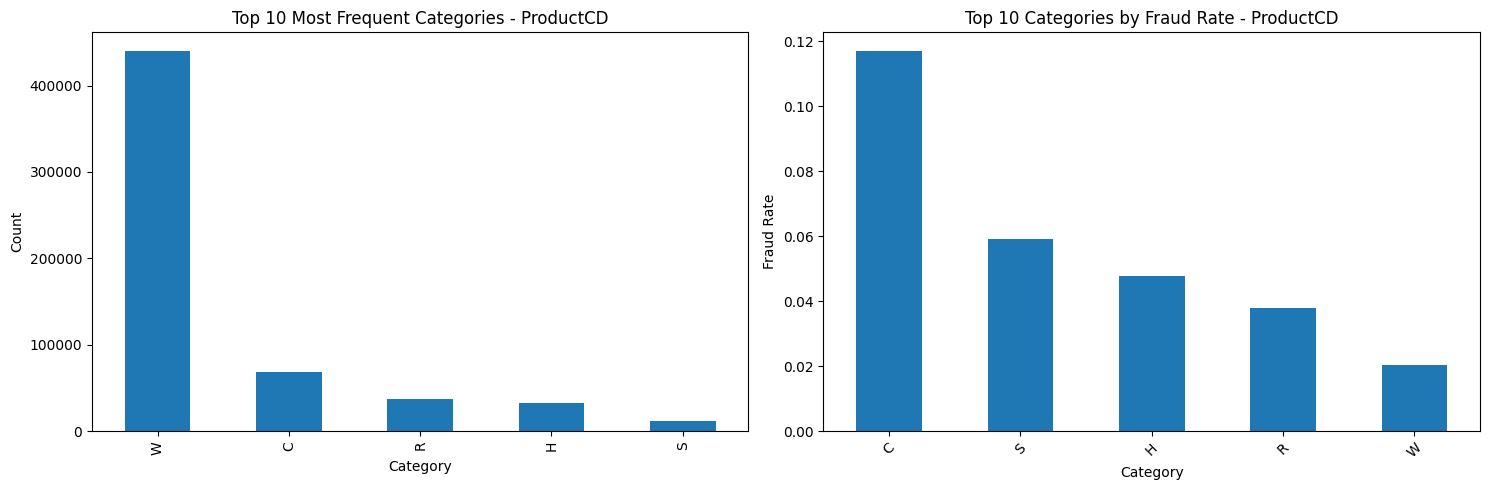


Analysis for ProductCD:
Number of unique values: 5
Missing values: 0 (0.00%)

Top 5 categories by frequency:
ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628


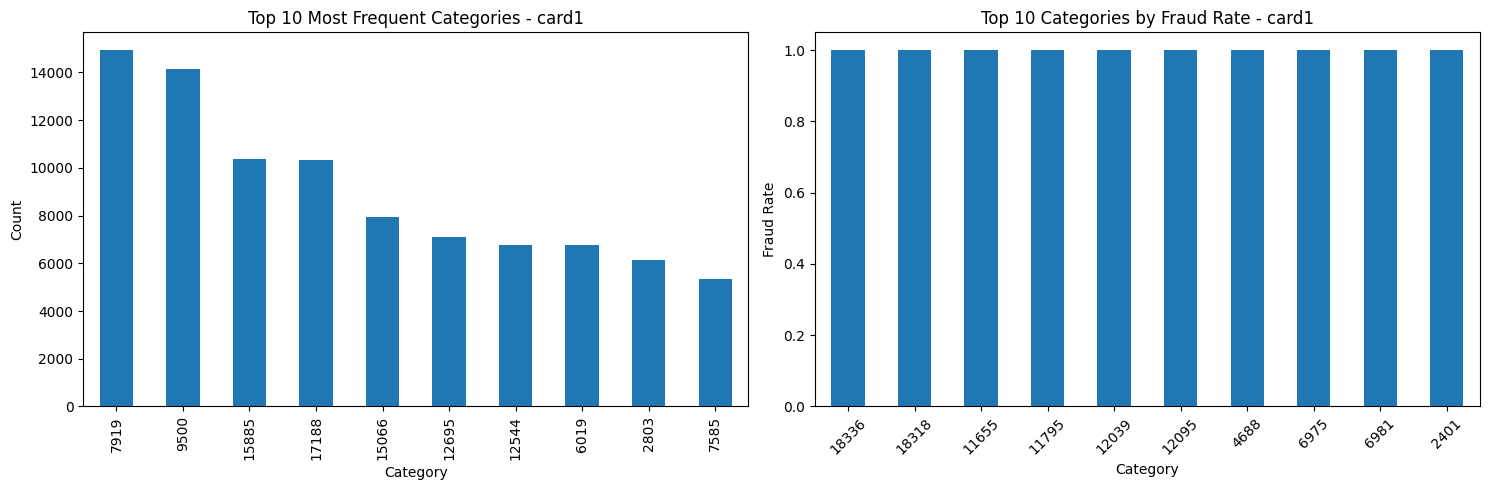


Analysis for card1:
Number of unique values: 13553
Missing values: 0 (0.00%)

Top 5 categories by frequency:
card1
7919     14932
9500     14162
15885    10361
17188    10344
15066     7945


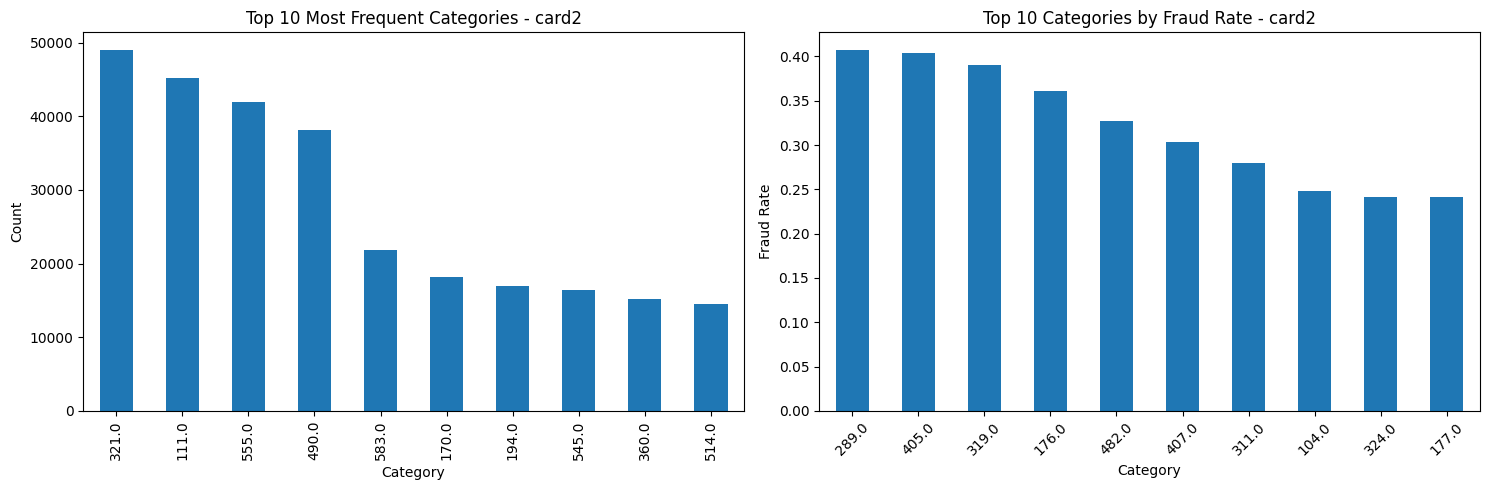


Analysis for card2:
Number of unique values: 500
Missing values: 8933 (1.51%)

Top 5 categories by frequency:
card2
321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803


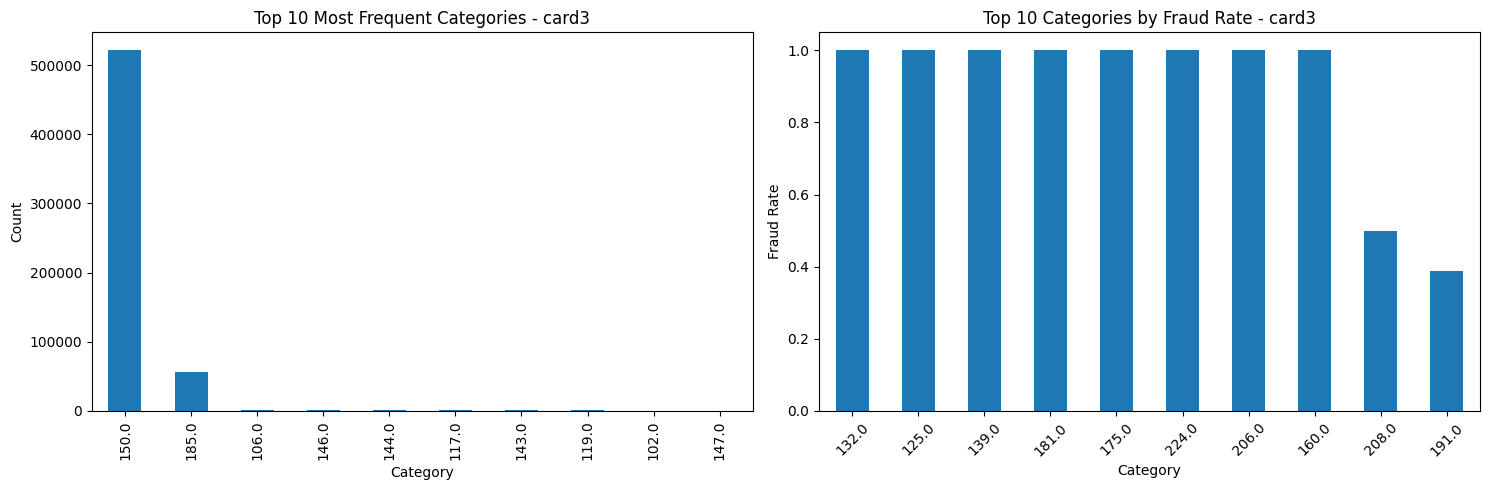


Analysis for card3:
Number of unique values: 114
Missing values: 1565 (0.27%)

Top 5 categories by frequency:
card3
150.0    521287
185.0     56346
106.0      1571
146.0      1252
144.0      1252


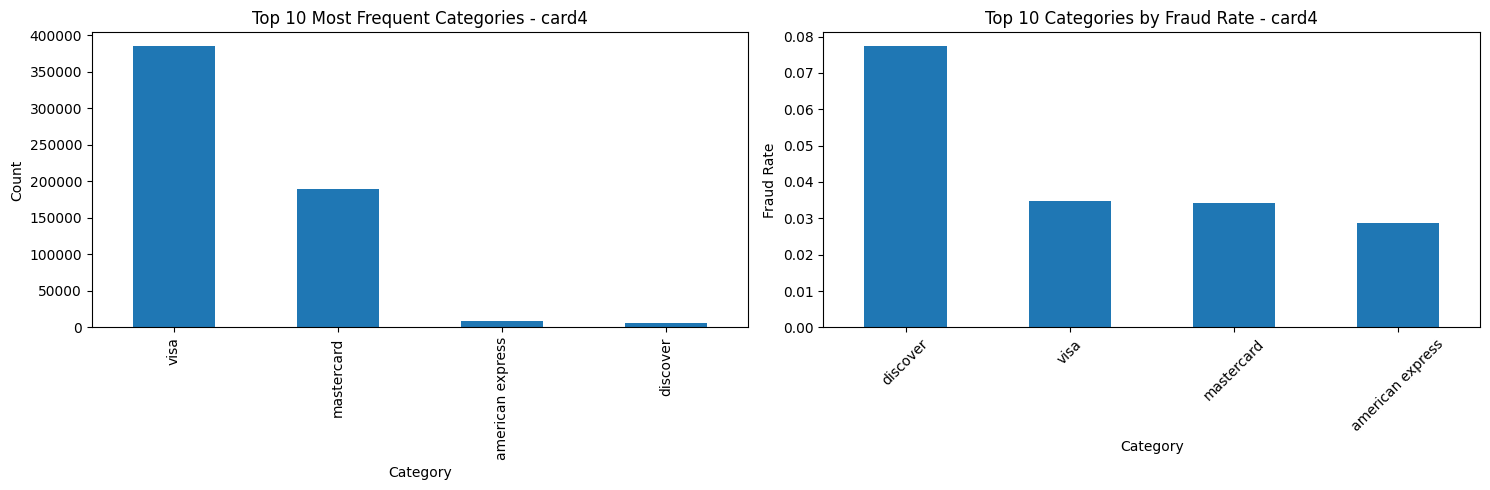


Analysis for card4:
Number of unique values: 4
Missing values: 1577 (0.27%)

Top 5 categories by frequency:
card4
visa                384767
mastercard          189217
american express      8328
discover              6651


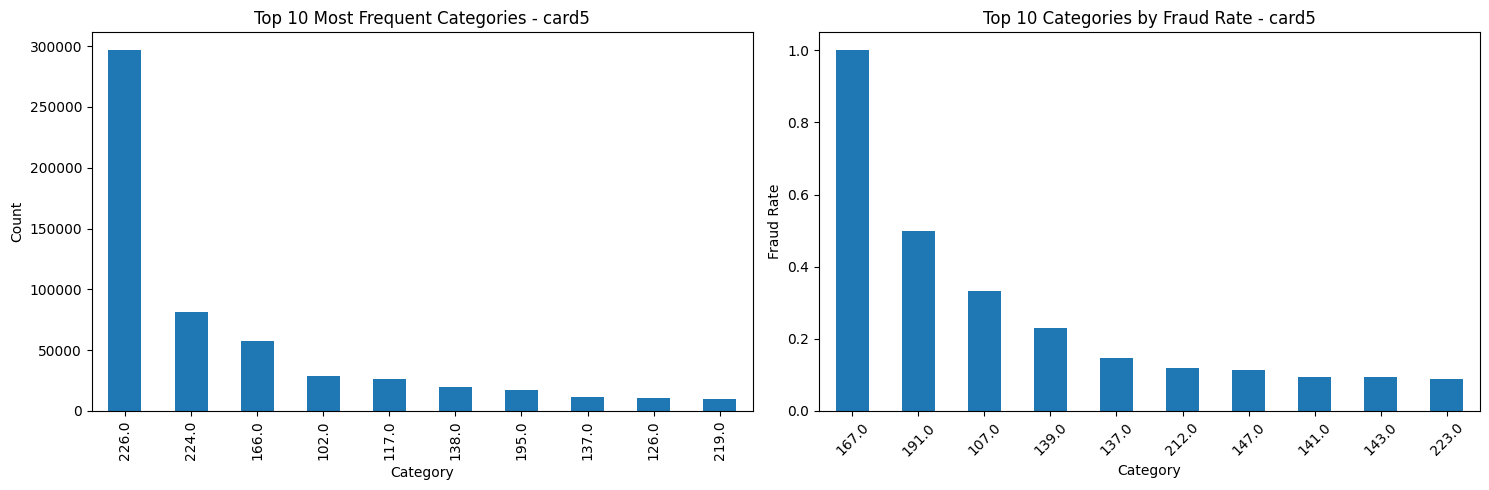


Analysis for card5:
Number of unique values: 119
Missing values: 4259 (0.72%)

Top 5 categories by frequency:
card5
226.0    296546
224.0     81513
166.0     57140
102.0     29105
117.0     25941


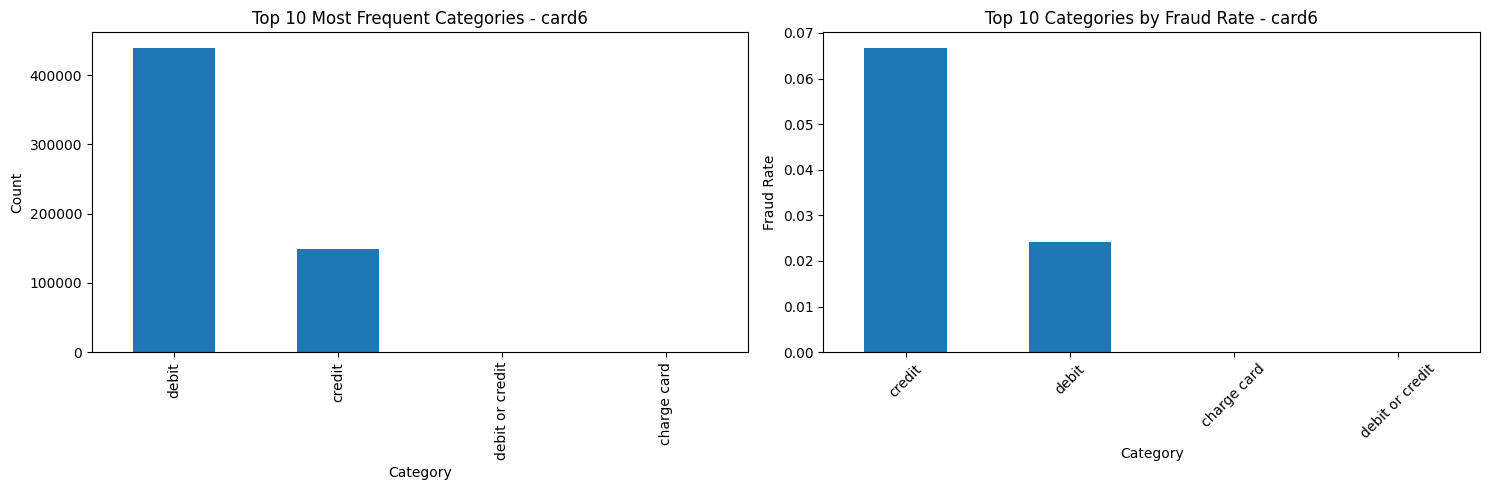


Analysis for card6:
Number of unique values: 4
Missing values: 1571 (0.27%)

Top 5 categories by frequency:
card6
debit              439938
credit             148986
debit or credit        30
charge card            15


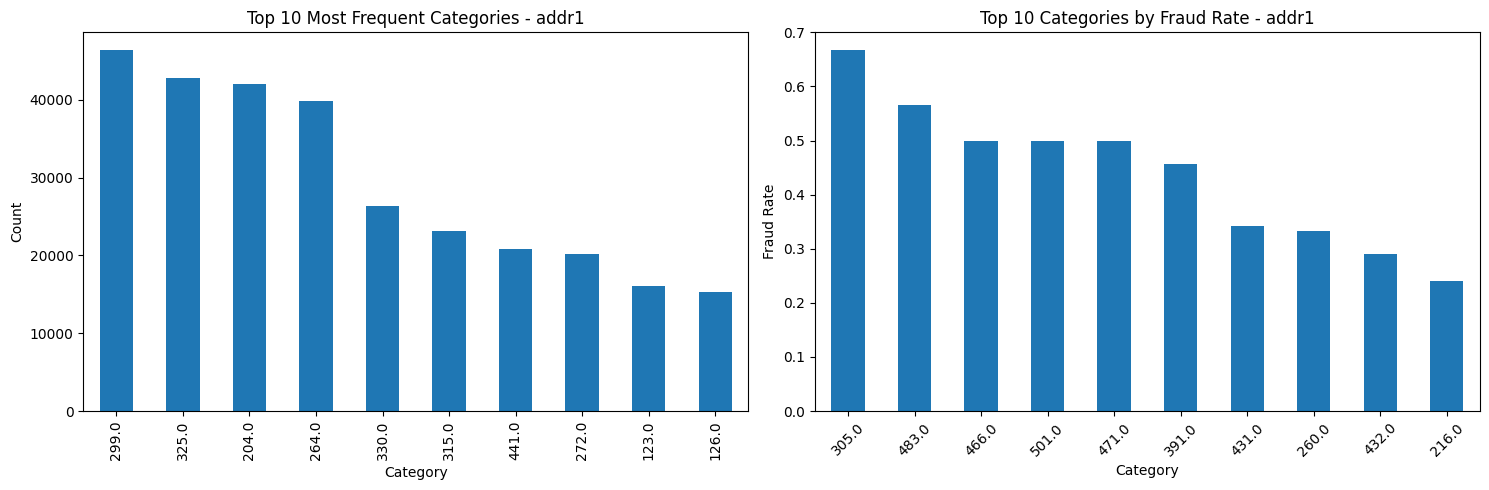


Analysis for addr1:
Number of unique values: 332
Missing values: 65706 (11.13%)

Top 5 categories by frequency:
addr1
299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287


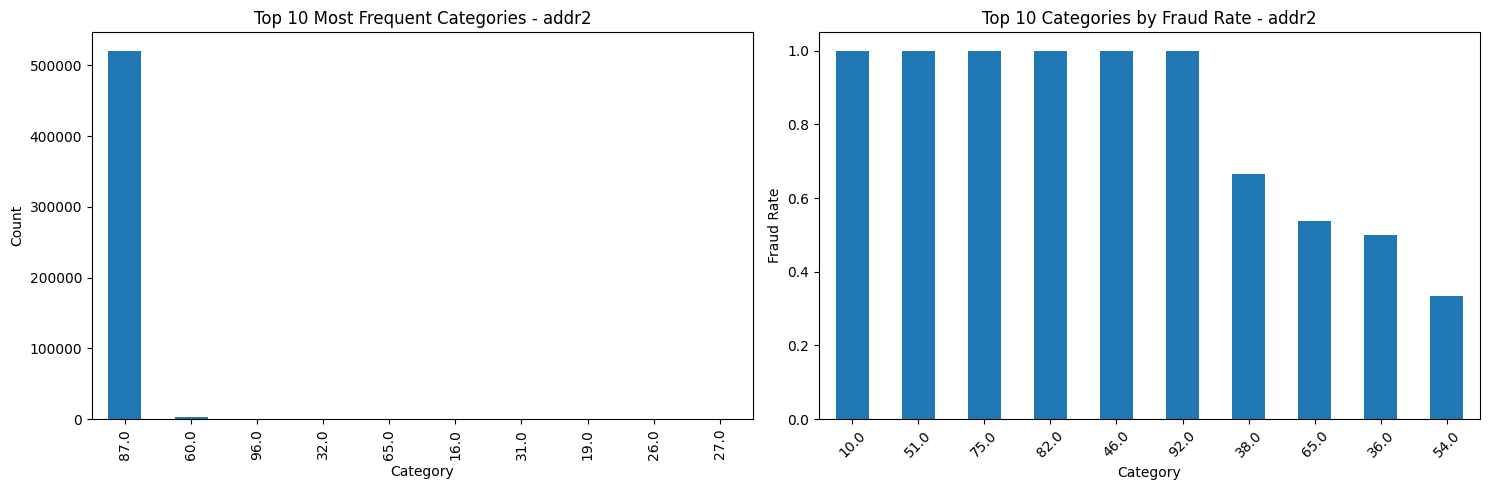


Analysis for addr2:
Number of unique values: 74
Missing values: 65706 (11.13%)

Top 5 categories by frequency:
addr2
87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82


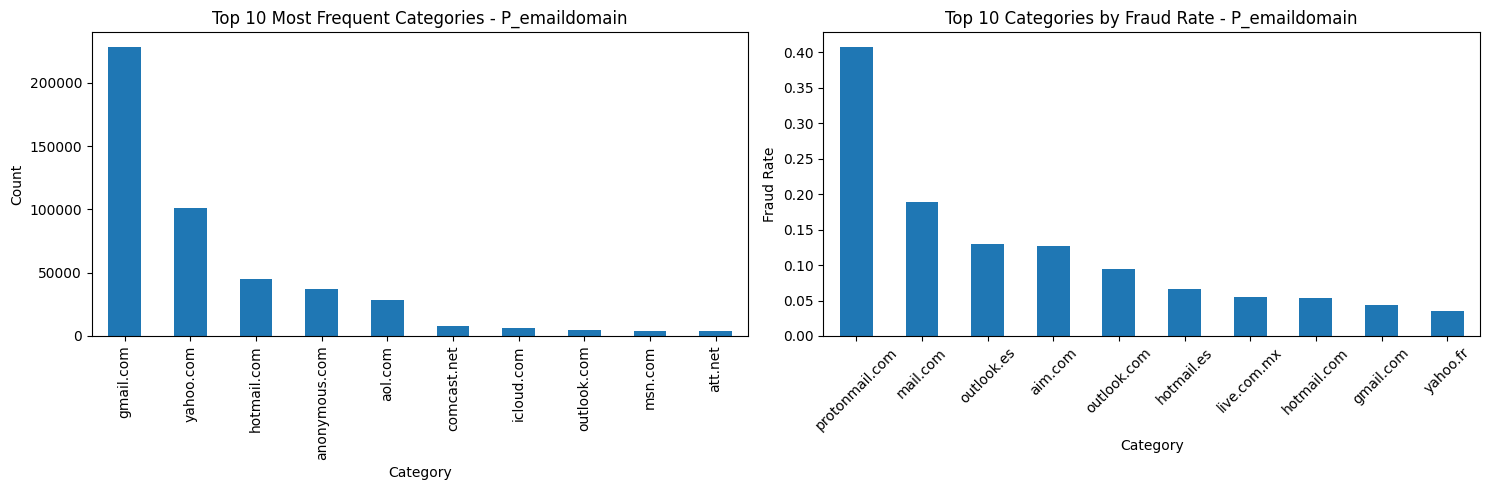


Analysis for P_emaildomain:
Number of unique values: 59
Missing values: 94456 (15.99%)

Top 5 categories by frequency:
P_emaildomain
gmail.com        228355
yahoo.com        100934
hotmail.com       45250
anonymous.com     36998
aol.com           28289


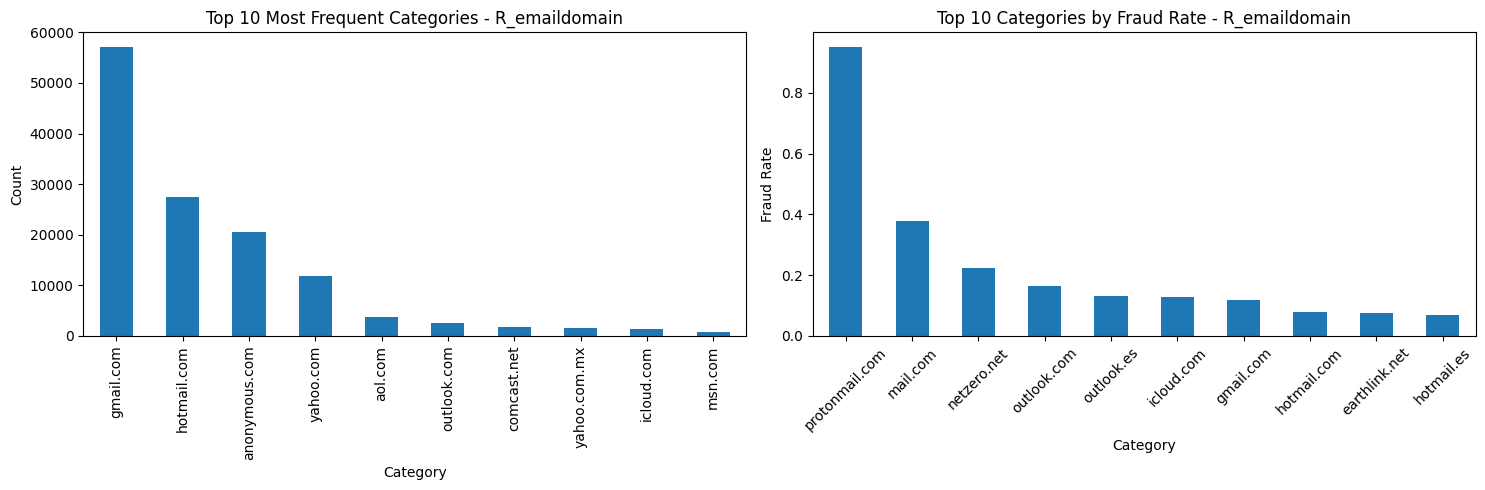


Analysis for R_emaildomain:
Number of unique values: 60
Missing values: 453249 (76.75%)

Top 5 categories by frequency:
R_emaildomain
gmail.com        57147
hotmail.com      27509
anonymous.com    20529
yahoo.com        11842
aol.com           3701


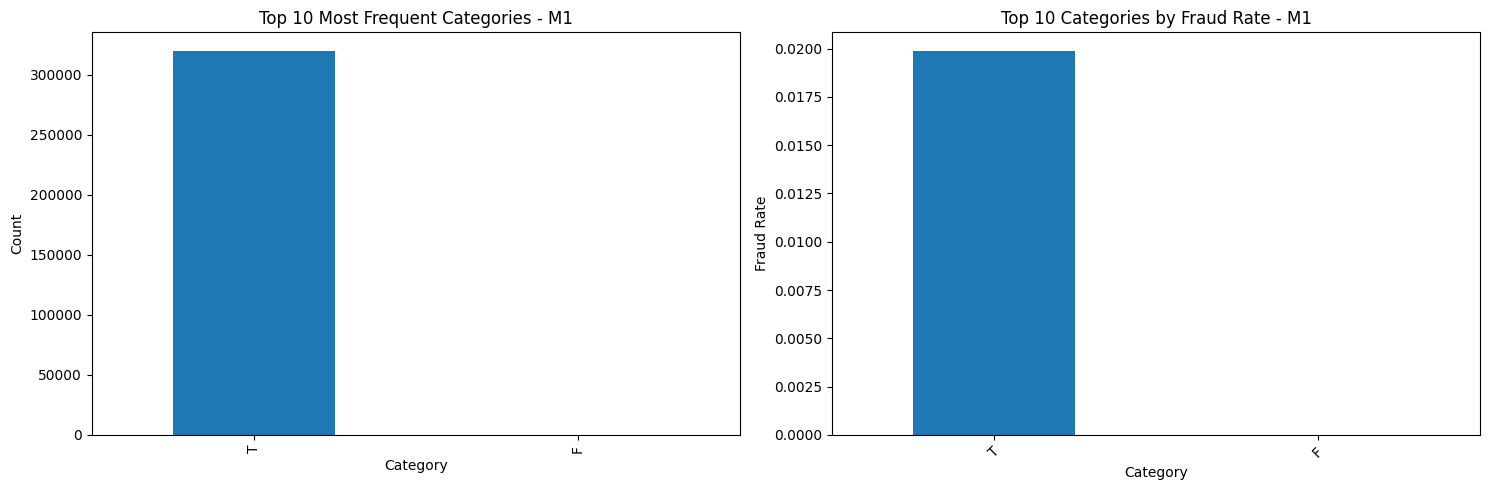


Analysis for M1:
Number of unique values: 2
Missing values: 271100 (45.91%)

Top 5 categories by frequency:
M1
T    319415
F        25


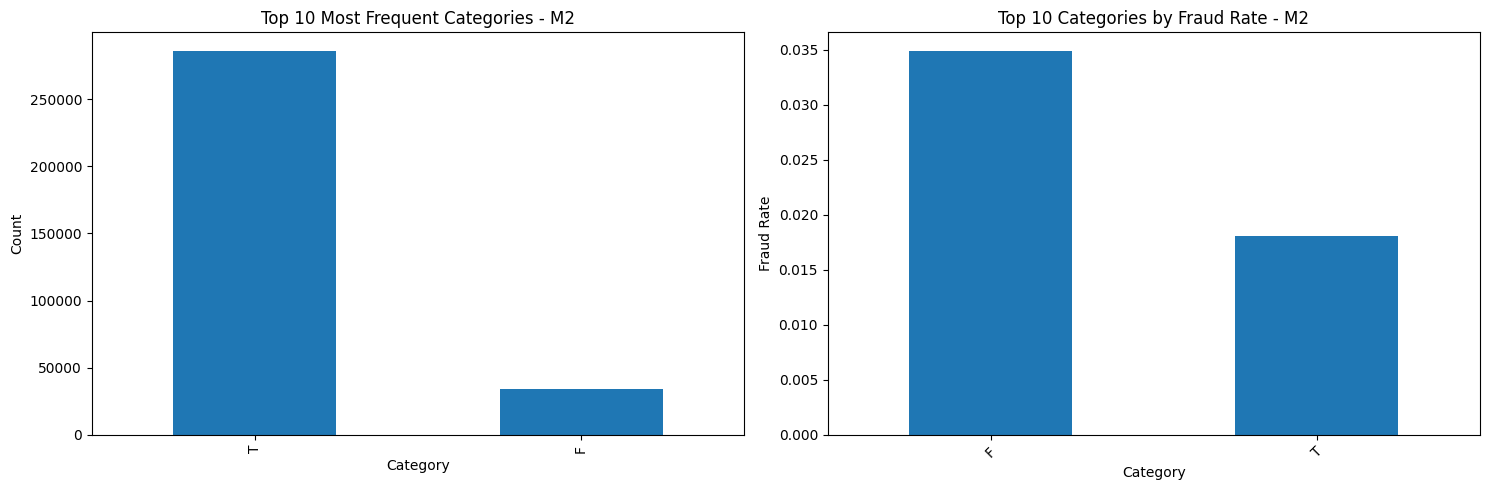


Analysis for M2:
Number of unique values: 2
Missing values: 271100 (45.91%)

Top 5 categories by frequency:
M2
T    285468
F     33972


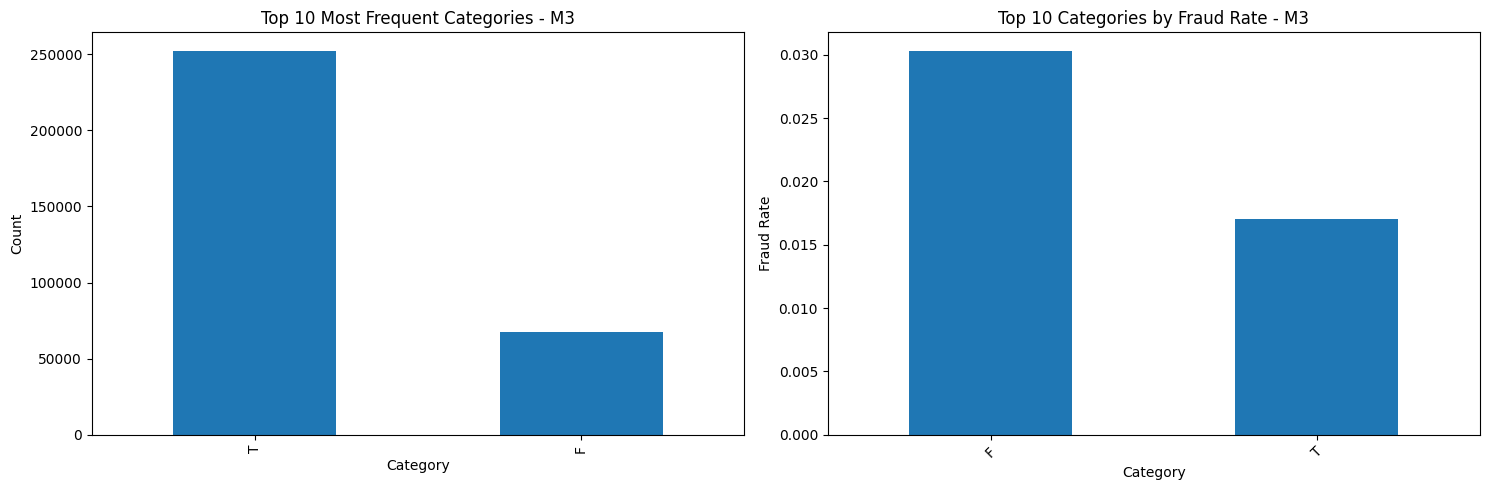


Analysis for M3:
Number of unique values: 2
Missing values: 271100 (45.91%)

Top 5 categories by frequency:
M3
T    251731
F     67709


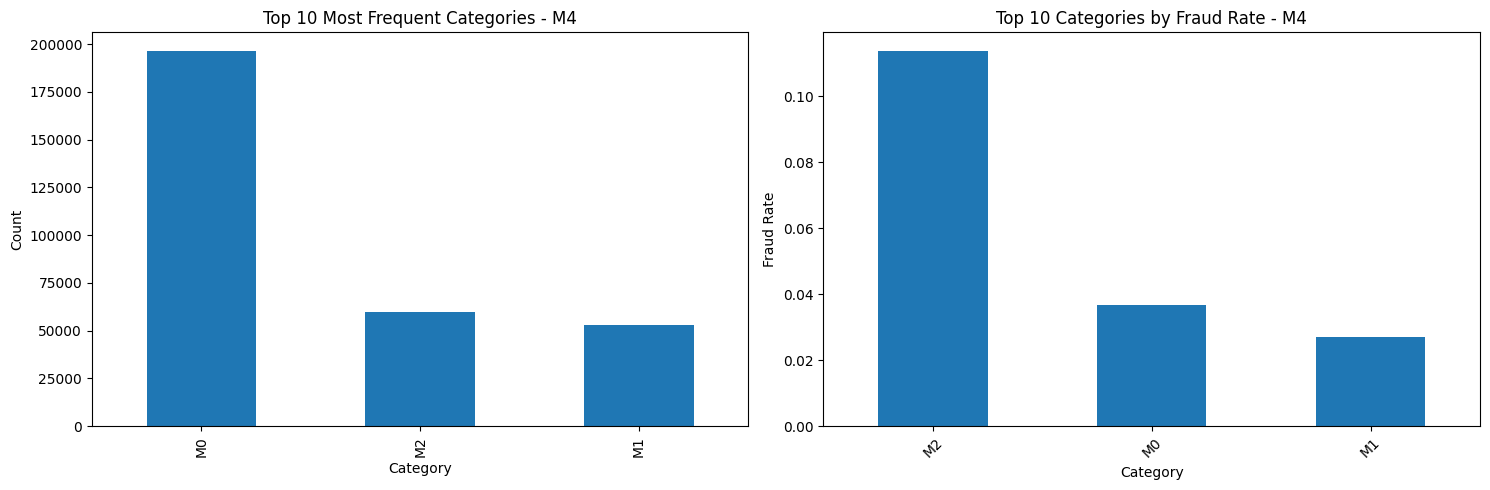


Analysis for M4:
Number of unique values: 3
Missing values: 281444 (47.66%)

Top 5 categories by frequency:
M4
M0    196405
M2     59865
M1     52826


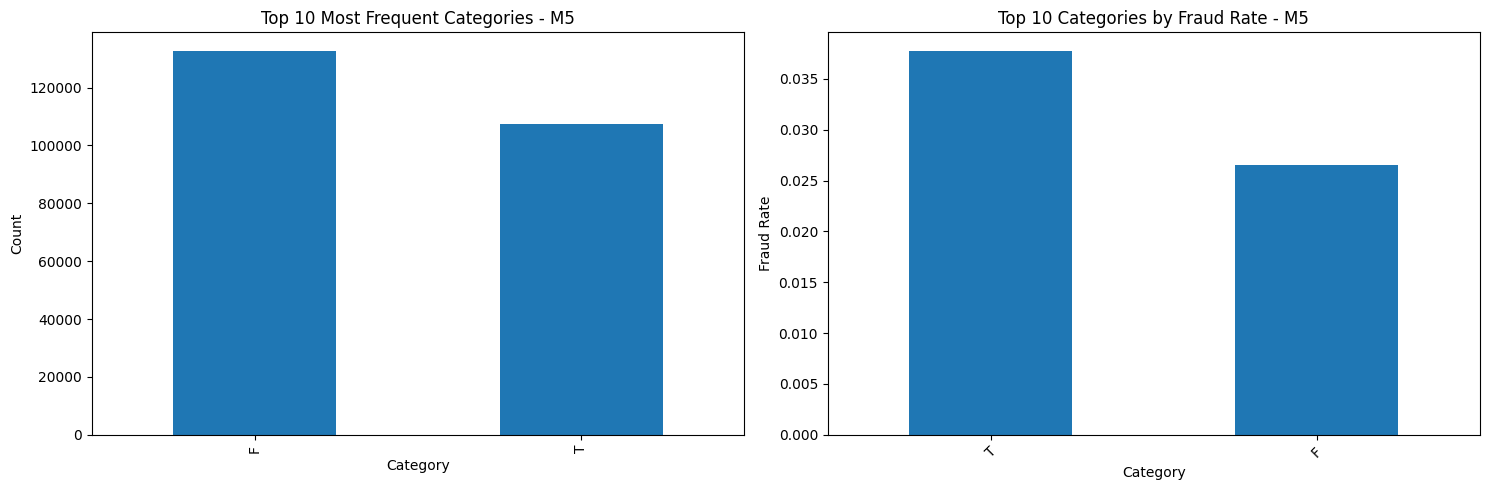


Analysis for M5:
Number of unique values: 2
Missing values: 350482 (59.35%)

Top 5 categories by frequency:
M5
F    132491
T    107567


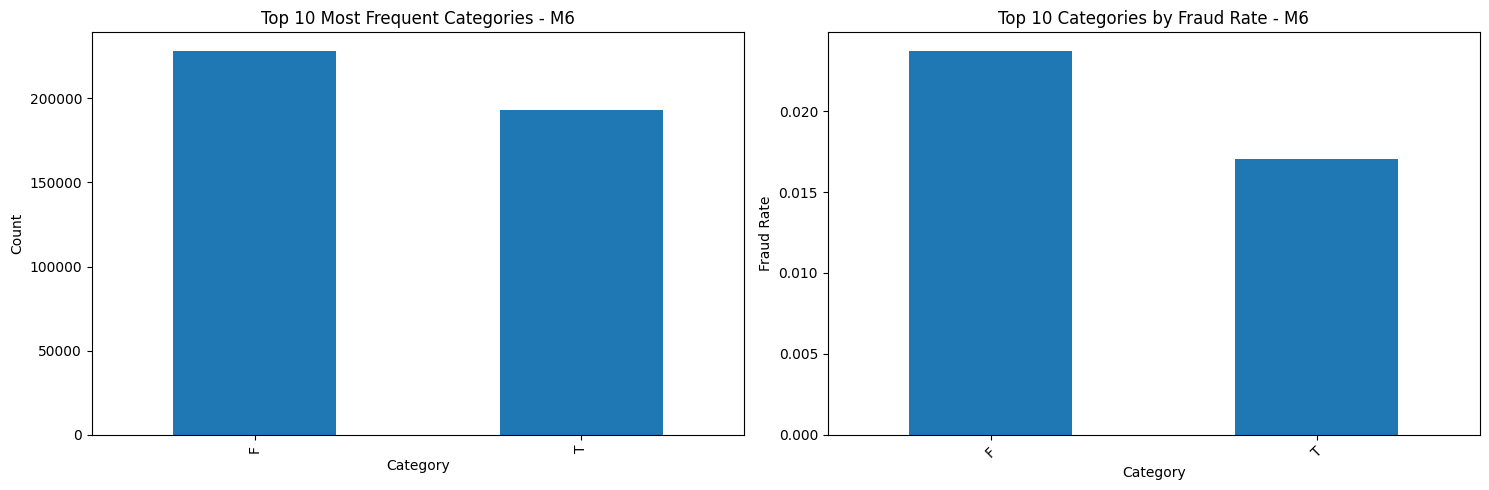


Analysis for M6:
Number of unique values: 2
Missing values: 169360 (28.68%)

Top 5 categories by frequency:
M6
F    227856
T    193324


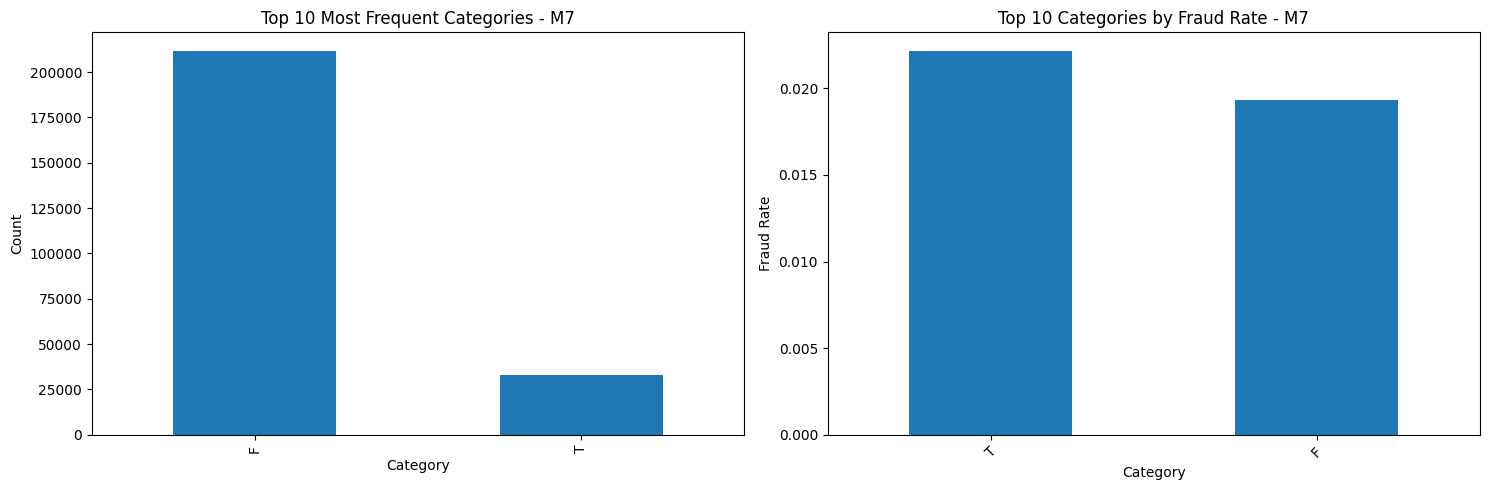


Analysis for M7:
Number of unique values: 2
Missing values: 346265 (58.64%)

Top 5 categories by frequency:
M7
F    211374
T     32901


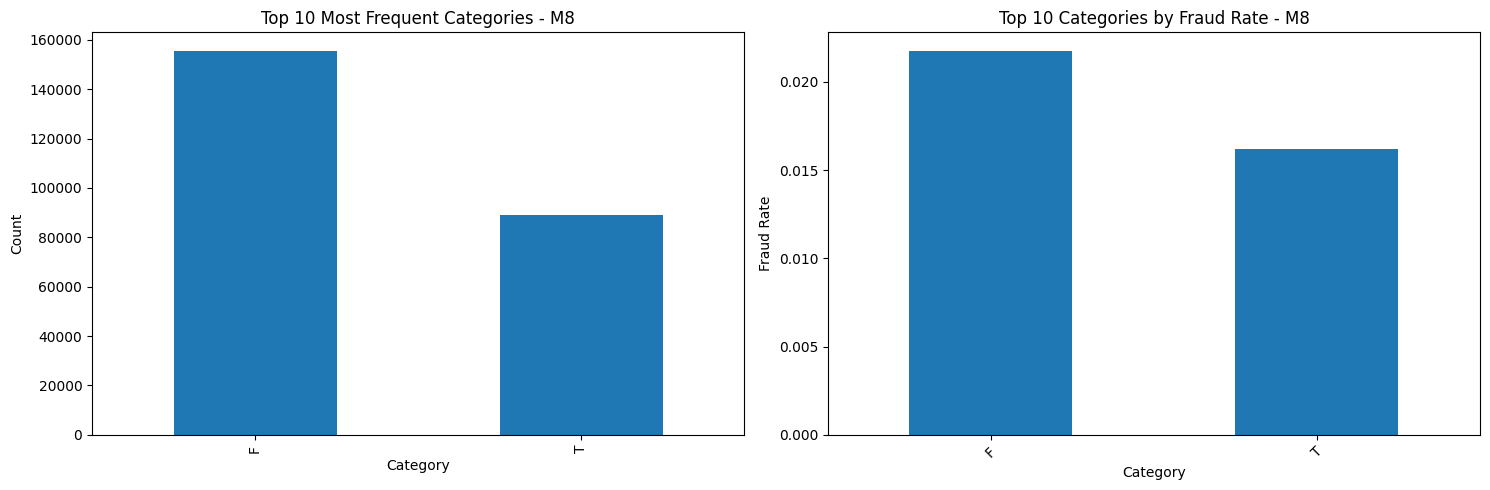


Analysis for M8:
Number of unique values: 2
Missing values: 346252 (58.63%)

Top 5 categories by frequency:
M8
F    155251
T     89037


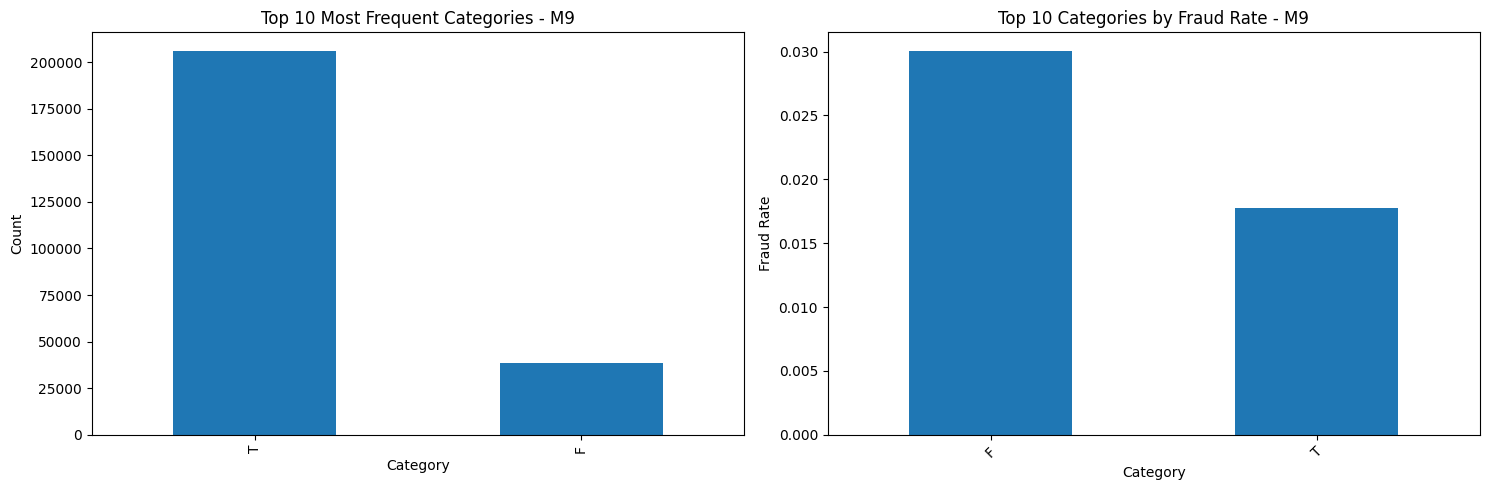


Analysis for M9:
Number of unique values: 2
Missing values: 346252 (58.63%)

Top 5 categories by frequency:
M9
T    205656
F     38632


In [41]:
# List of categorical features to analyze
categorical_features = ['ProductCD'] + [f'card{i}' for i in range(1,7)] + ['addr1', 'addr2'] + \
                      ['P_emaildomain', 'R_emaildomain'] + [f'M{i}' for i in range(1,10)]

def analyze_categorical(feature):
    if feature not in train.columns:
        return None
    
    # Get value counts and fraud rates
    value_counts = train[feature].value_counts()
    fraud_rates = train.groupby(feature)['isFraud'].mean().sort_values(ascending=False)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Top 10 most frequent categories
    value_counts.head(10).plot(kind='bar', ax=ax1)
    ax1.set_title(f'Top 10 Most Frequent Categories - {feature}')
    ax1.set_xlabel('Category')
    ax1.set_ylabel('Count')
    plt.xticks(rotation=45)
    
    # Plot 2: Fraud rate by category (top 10)
    fraud_rates.head(10).plot(kind='bar', ax=ax2)
    ax2.set_title(f'Top 10 Categories by Fraud Rate - {feature}')
    ax2.set_xlabel('Category')
    ax2.set_ylabel('Fraud Rate')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nAnalysis for {feature}:")
    print(f"Number of unique values: {len(value_counts)}")
    print(f"Missing values: {train[feature].isnull().sum()} ({train[feature].isnull().mean():.2%})")
    print("\nTop 5 categories by frequency:")
    print(value_counts.head().to_string())

# Analyze each categorical feature
for feature in categorical_features:
    analyze_categorical(feature)


## 7. Dist, Count & Time Features


### 7.1. Distance

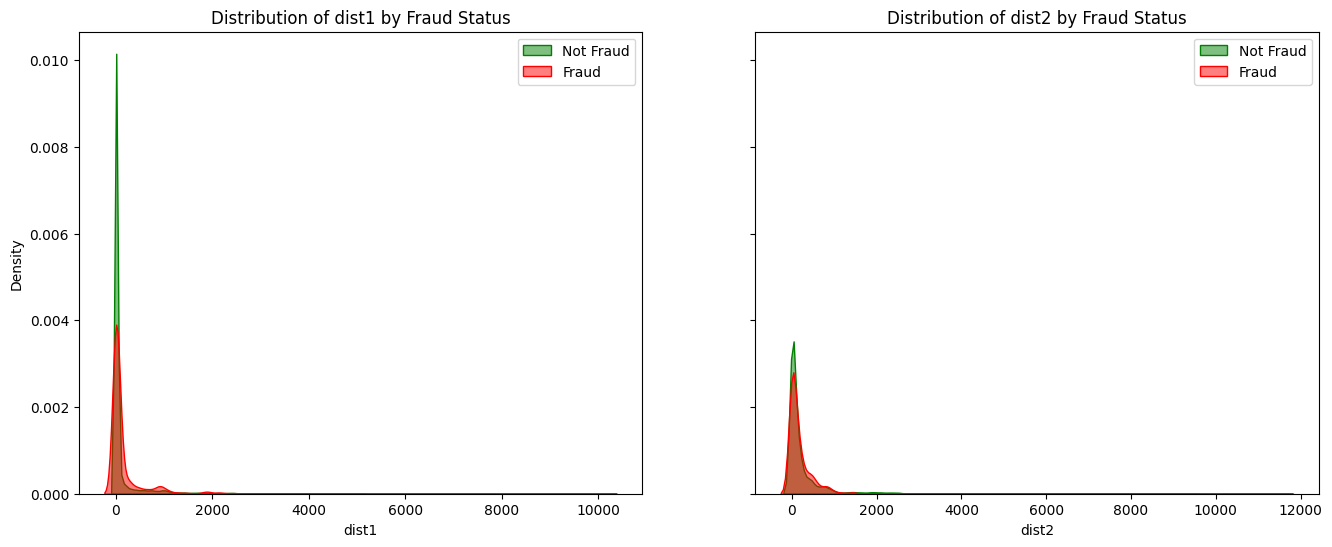

In [42]:
# fraud per distance analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# dist1
sns.kdeplot(train.loc[train['isFraud'] == 0, 'dist1'].dropna(), label='Not Fraud', color='g', fill=True, alpha=0.5, ax=axes[0])
sns.kdeplot(train.loc[train['isFraud'] == 1, 'dist1'].dropna(), label='Fraud',     color='r', fill=True, alpha=0.5, ax=axes[0])
axes[0].set_title('Distribution of dist1 by Fraud Status')
axes[0].set_xlabel('dist1')
axes[0].set_ylabel('Density')
axes[0].legend()

# dist2
sns.kdeplot(train.loc[train['isFraud'] == 0, 'dist2'].dropna(), label='Not Fraud', color='g', fill=True, alpha=0.5, ax=axes[1])
sns.kdeplot(train.loc[train['isFraud'] == 1, 'dist2'].dropna(), label='Fraud',     color='r', fill=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Distribution of dist2 by Fraud Status')
axes[1].set_xlabel('dist2')
axes[1].legend()
plt.show()

### 7.2. C1–C14 (counts):

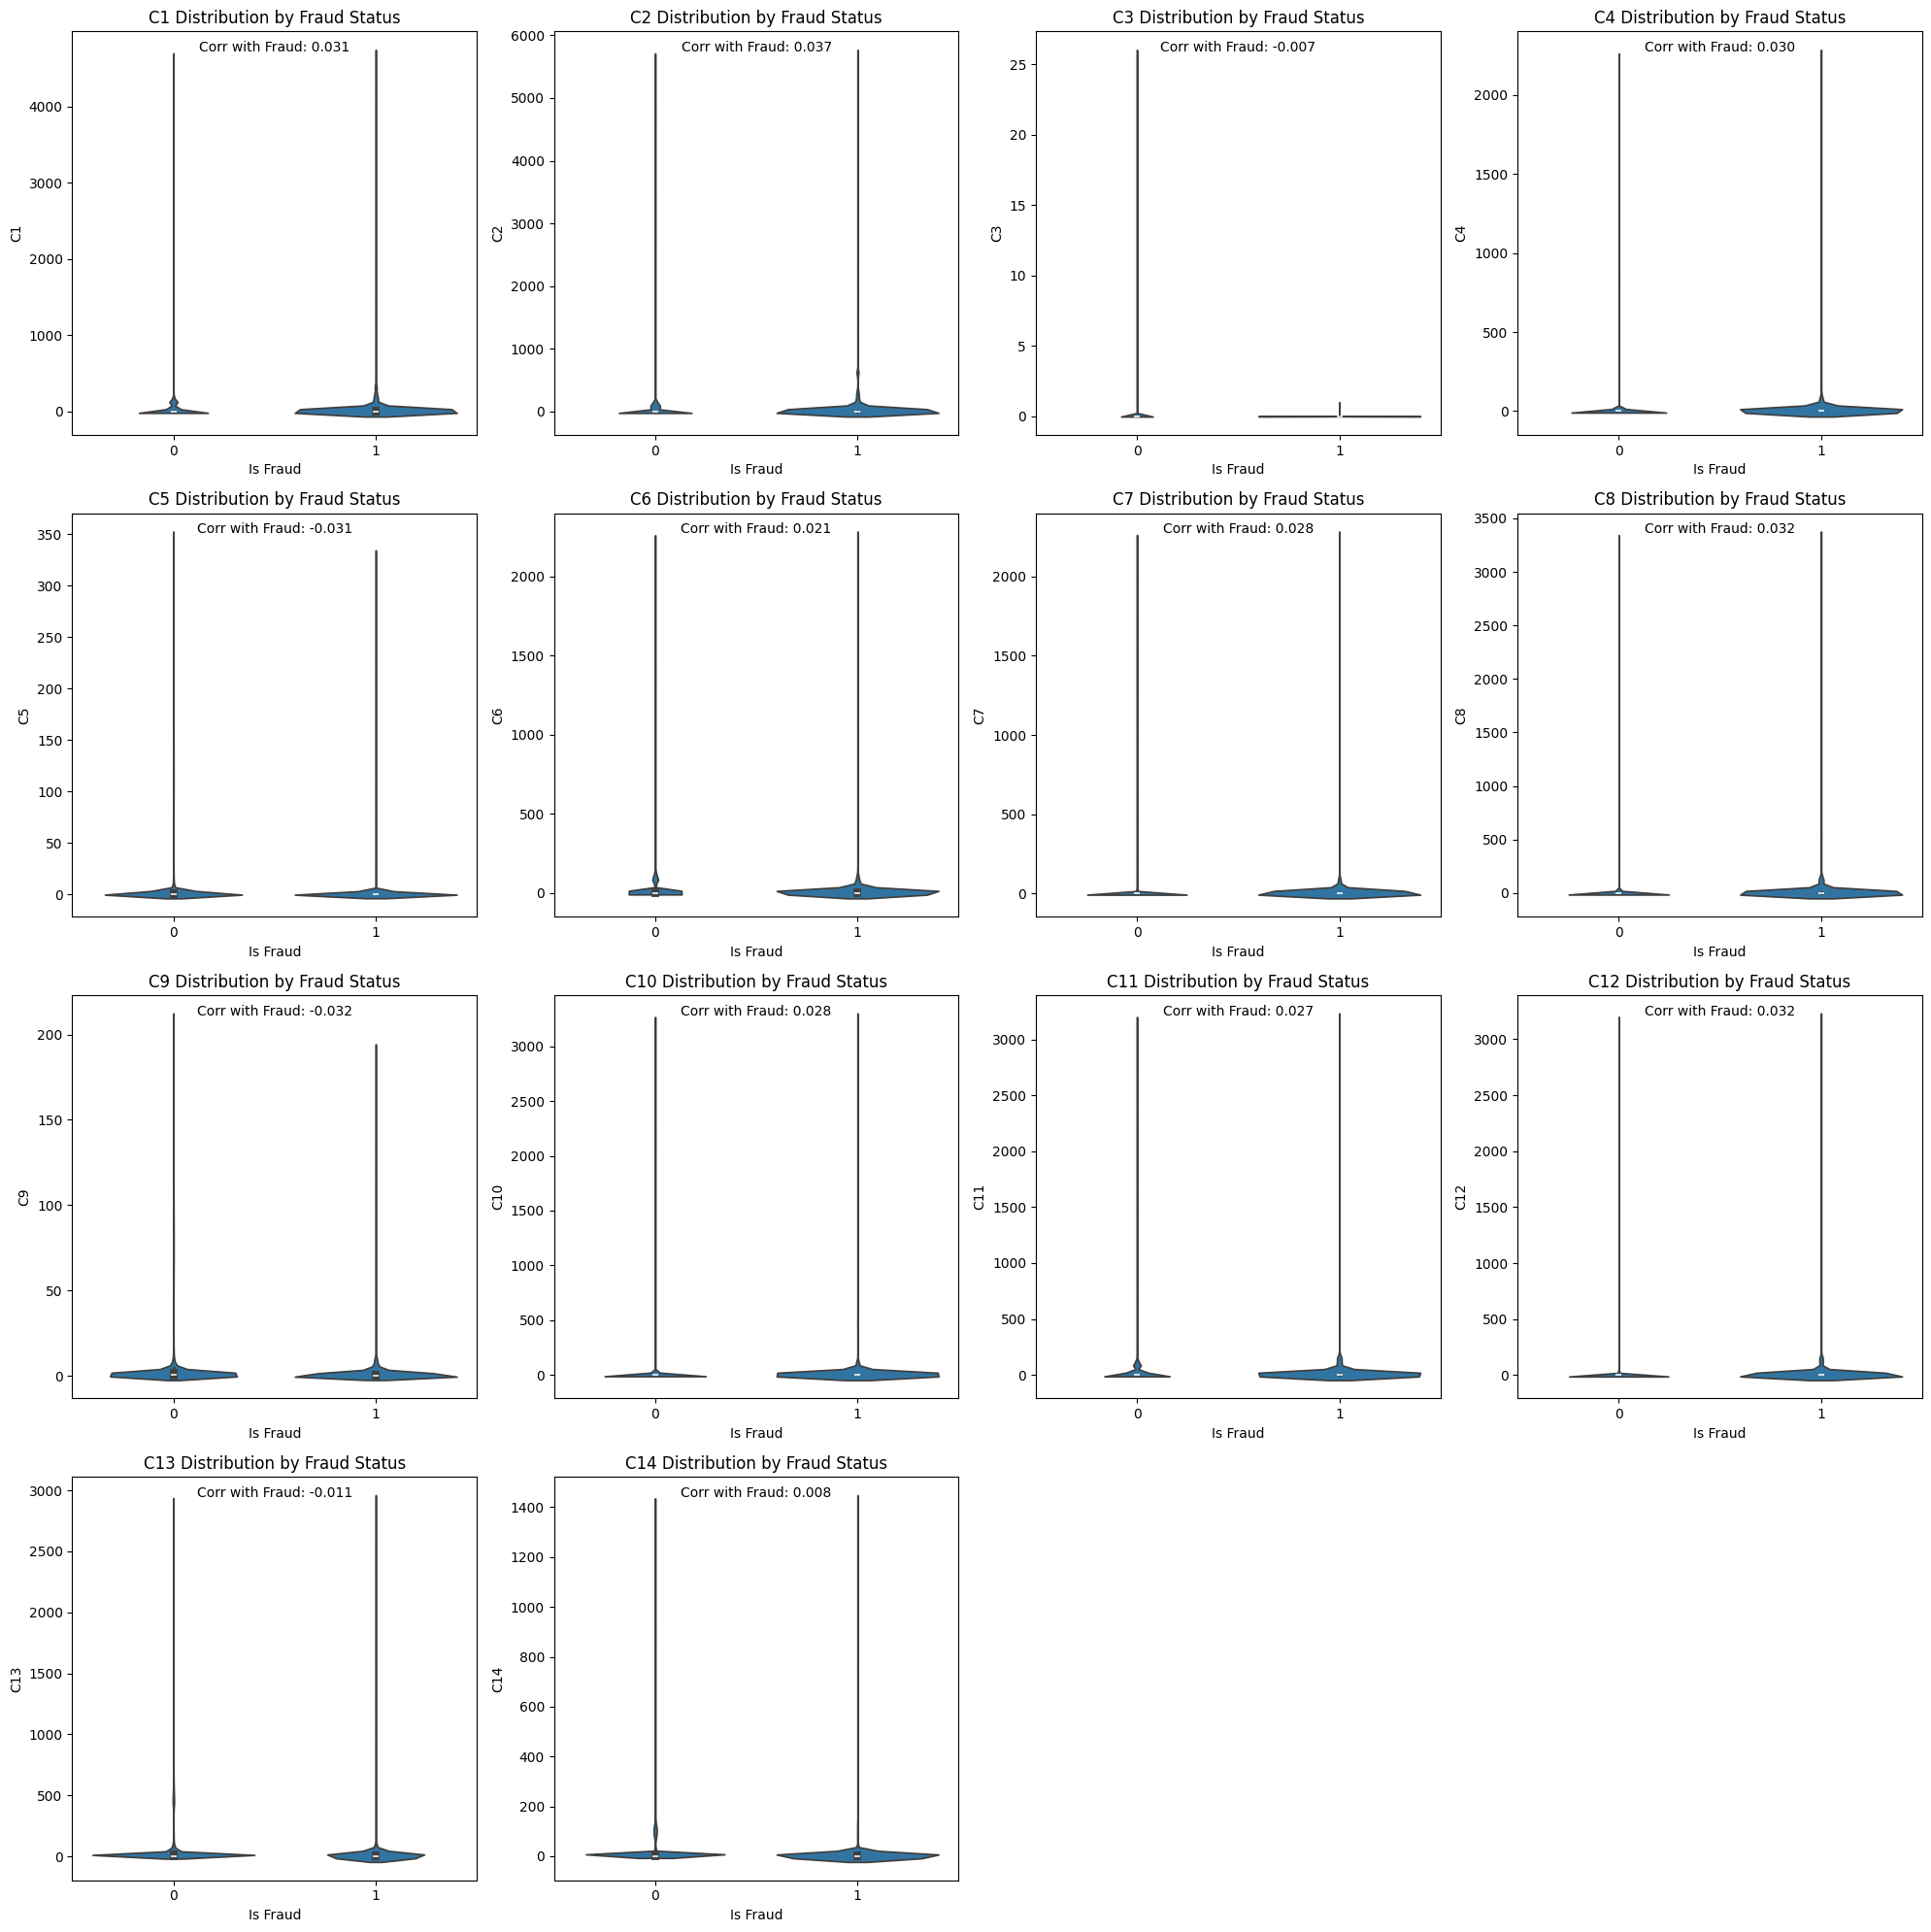


Count Features Statistics:

C1:
Missing values: 0 (0.00%)
Mean value: 14.09
Correlation with fraud: 0.031
Mean for non-fraud: 13.31
Mean for fraud: 35.54
----------------------------------------

C2:
Missing values: 0 (0.00%)
Mean value: 15.27
Correlation with fraud: 0.037
Mean for non-fraud: 14.17
Mean for fraud: 45.51
----------------------------------------

C3:
Missing values: 0 (0.00%)
Mean value: 0.01
Correlation with fraud: -0.007
Mean for non-fraud: 0.01
Mean for fraud: 0.00
----------------------------------------

C4:
Missing values: 0 (0.00%)
Mean value: 4.09
Correlation with fraud: 0.030
Mean for non-fraud: 3.69
Mean for fraud: 15.08
----------------------------------------

C5:
Missing values: 0 (0.00%)
Mean value: 5.57
Correlation with fraud: -0.031
Mean for non-fraud: 5.72
Mean for fraud: 1.41
----------------------------------------

C6:
Missing values: 0 (0.00%)
Mean value: 9.07
Correlation with fraud: 0.021
Mean for non-fraud: 8.79
Mean for fraud: 16.92
-------------

In [43]:
# Analyze count features (C1-C14)
count_features = [f'C{i}' for i in range(1, 15)]

# Create a figure for count features distribution
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.ravel()

# Plot distribution for each count feature
for idx, feature in enumerate(count_features):
    if feature in train.columns:
        # Create violin plot split by fraud status
        sns.violinplot(data=train, x='isFraud', y=feature, ax=axes[idx])
        axes[idx].set_title(f'{feature} Distribution by Fraud Status')
        axes[idx].set_xlabel('Is Fraud')
        
        # Calculate and display correlation with fraud
        correlation = train[[feature, 'isFraud']].corr().iloc[0,1]
        axes[idx].text(0.5, 0.95, f'Corr with Fraud: {correlation:.3f}', 
                      horizontalalignment='center', transform=axes[idx].transAxes)

# Remove empty subplots if any
for idx in range(len(count_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Print statistics for count features
print("\nCount Features Statistics:")
for feature in count_features:
    if feature in train.columns:
        print(f"\n{feature}:")
        print(f"Missing values: {train[feature].isnull().sum()} ({train[feature].isnull().mean():.2%})")
        print(f"Mean value: {train[feature].mean():.2f}")
        print(f"Correlation with fraud: {train[[feature, 'isFraud']].corr().iloc[0,1]:.3f}")
        
        # Calculate mean values for fraud vs non-fraud
        mean_by_fraud = train.groupby('isFraud')[feature].mean()
        print(f"Mean for non-fraud: {mean_by_fraud[0]:.2f}")
        print(f"Mean for fraud: {mean_by_fraud[1]:.2f}")
        print("-" * 40)

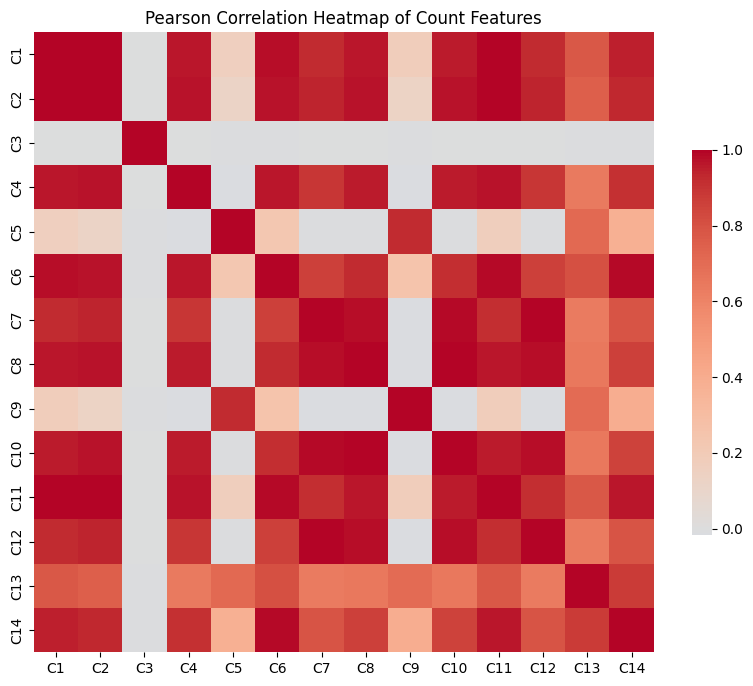

In [ ]:
# Compute Pearson and Spearman correlation matrices
pearson_corr = train[count_features].corr(method='pearson')

# Plot Pearson correlation heatmap (show only lower triangle for clarity)
plt.figure(figsize=(10, 10))
sns.heatmap(pearson_corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .5}, linewidths=0)
plt.title('Pearson Correlation Heatmap of Count Features')
plt.show()

In [75]:
_ , colsToDrop = drop_correlated_features(train[count_features])

Correlation threshold: 0.9
Dropping 10 correlated features:
 • C8
 • C4
 • C14
 • C9
 • C10
 • C2
 • C6
 • C11
 • C7
 • C12


In [76]:
train = train.drop(columns=colsToDrop, axis='columns')

### 7.3. D1–D15 (timedeltas)


We see that timedeltas are increasing over time (like transactionDT) (apart from D9)

In [77]:
def plot_d_cols():
    fig, axes = plt.subplots(5, 3, figsize=(20, 24), squeeze=False)
    axes = axes.flatten()

    for idx, i in enumerate(range(1,16)):
        ax = axes[idx]
        col = 'D'+str(i)
        # scatter plot of D columns by TransactionDT
        ax.scatter(train['TransactionDT'], train[col])
        ax.set_title(f'{col}')
        ax.set_xlabel('Transaction DT')
        ax.set_ylabel(col)

    plt.tight_layout()
    plt.show()

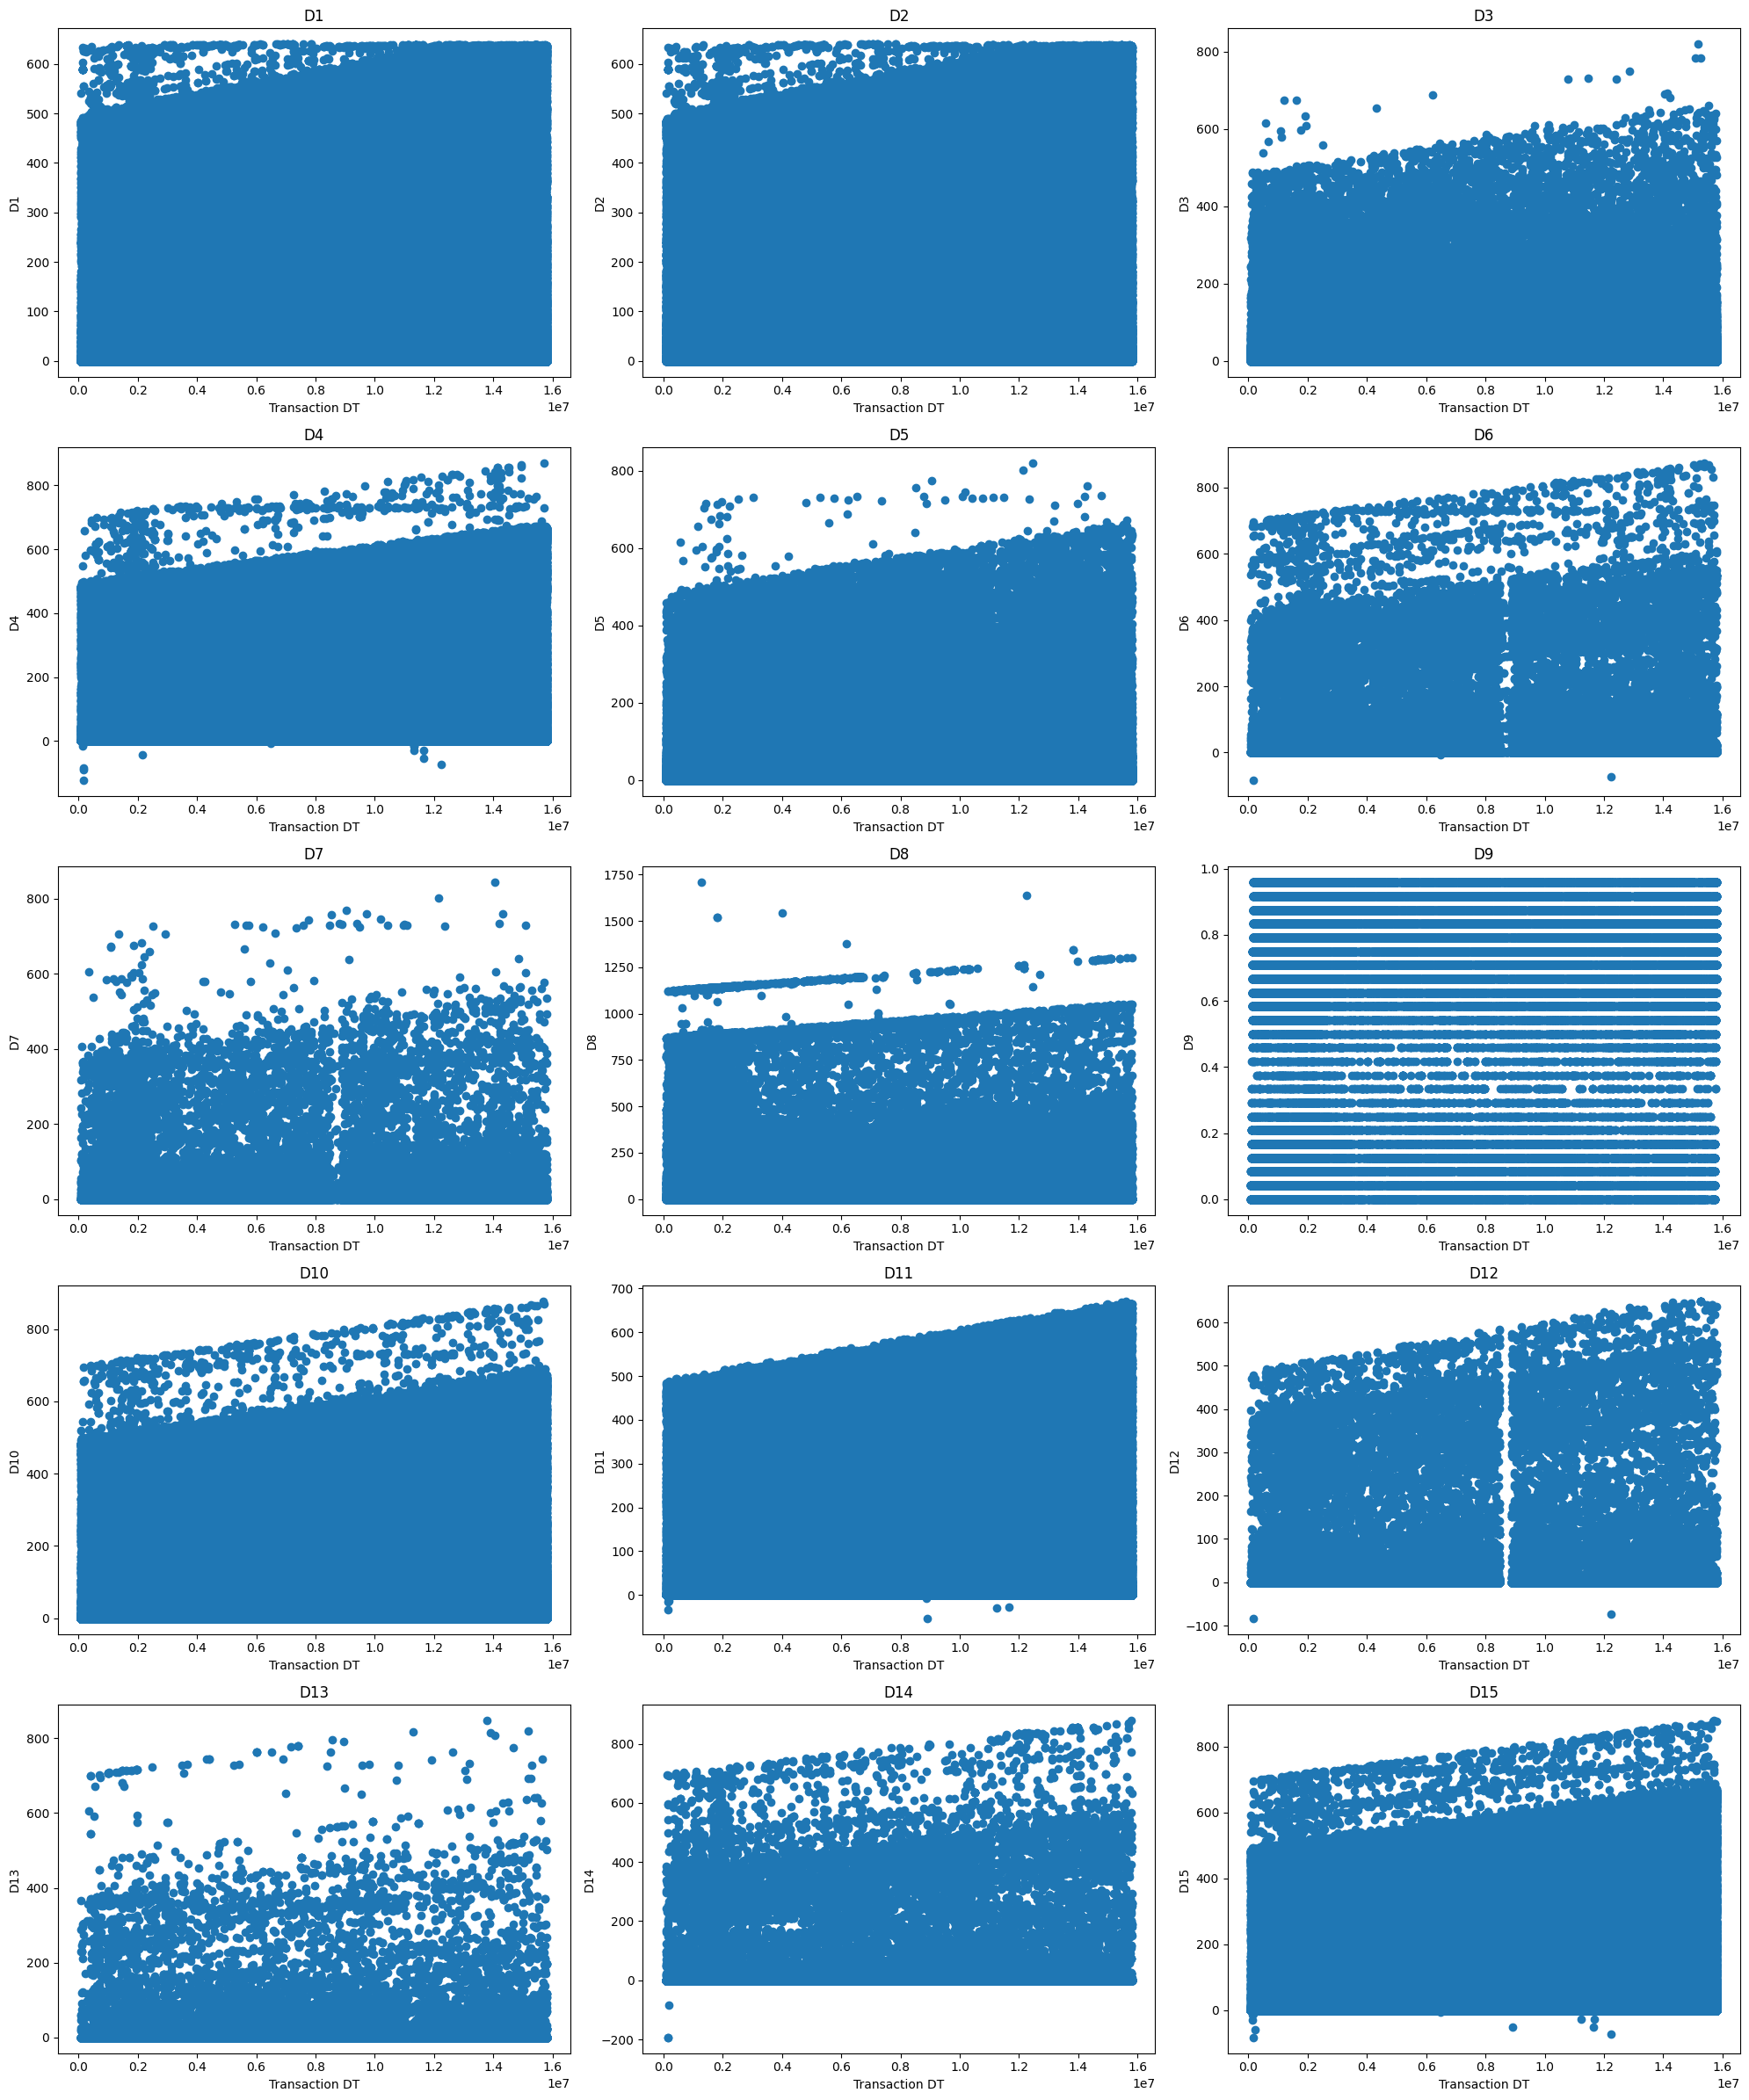

In [78]:
plot_d_cols()

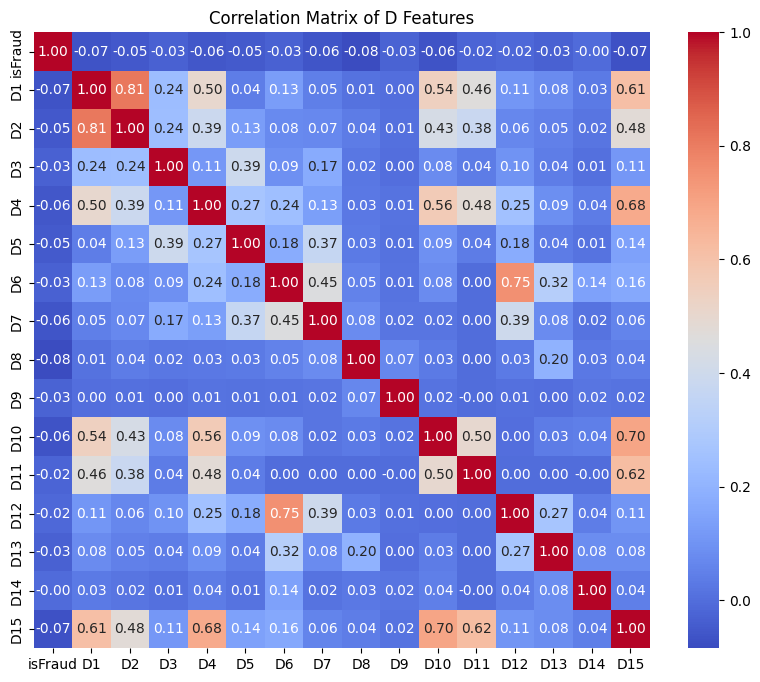

In [57]:
# D features correlation analysis 
d_cols = [f'D{i}' for i in range(1, 16) if f'D{i}' in train.columns]
d_data = train[d_cols].copy()
# Fill missing values with the mean of each column
d_data.fillna(d_data.mean(), inplace=True)
# Standardize the data
scaler = StandardScaler()
d_data_scaled = scaler.fit_transform(d_data)
d_data_scaled = pd.DataFrame(d_data_scaled, columns=d_cols)
# Compute the correlation matrix
corr_matrix = pd.concat([train['isFraud'],d_data_scaled], axis=1).corr()
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of D Features') 
plt.show()


Timedeltas features are measuring time (in days) passed from a certain time in the past, so in order to get some value over these features, we will get the time difference from the D\<index\> feature to the transactionDT (converted to days)

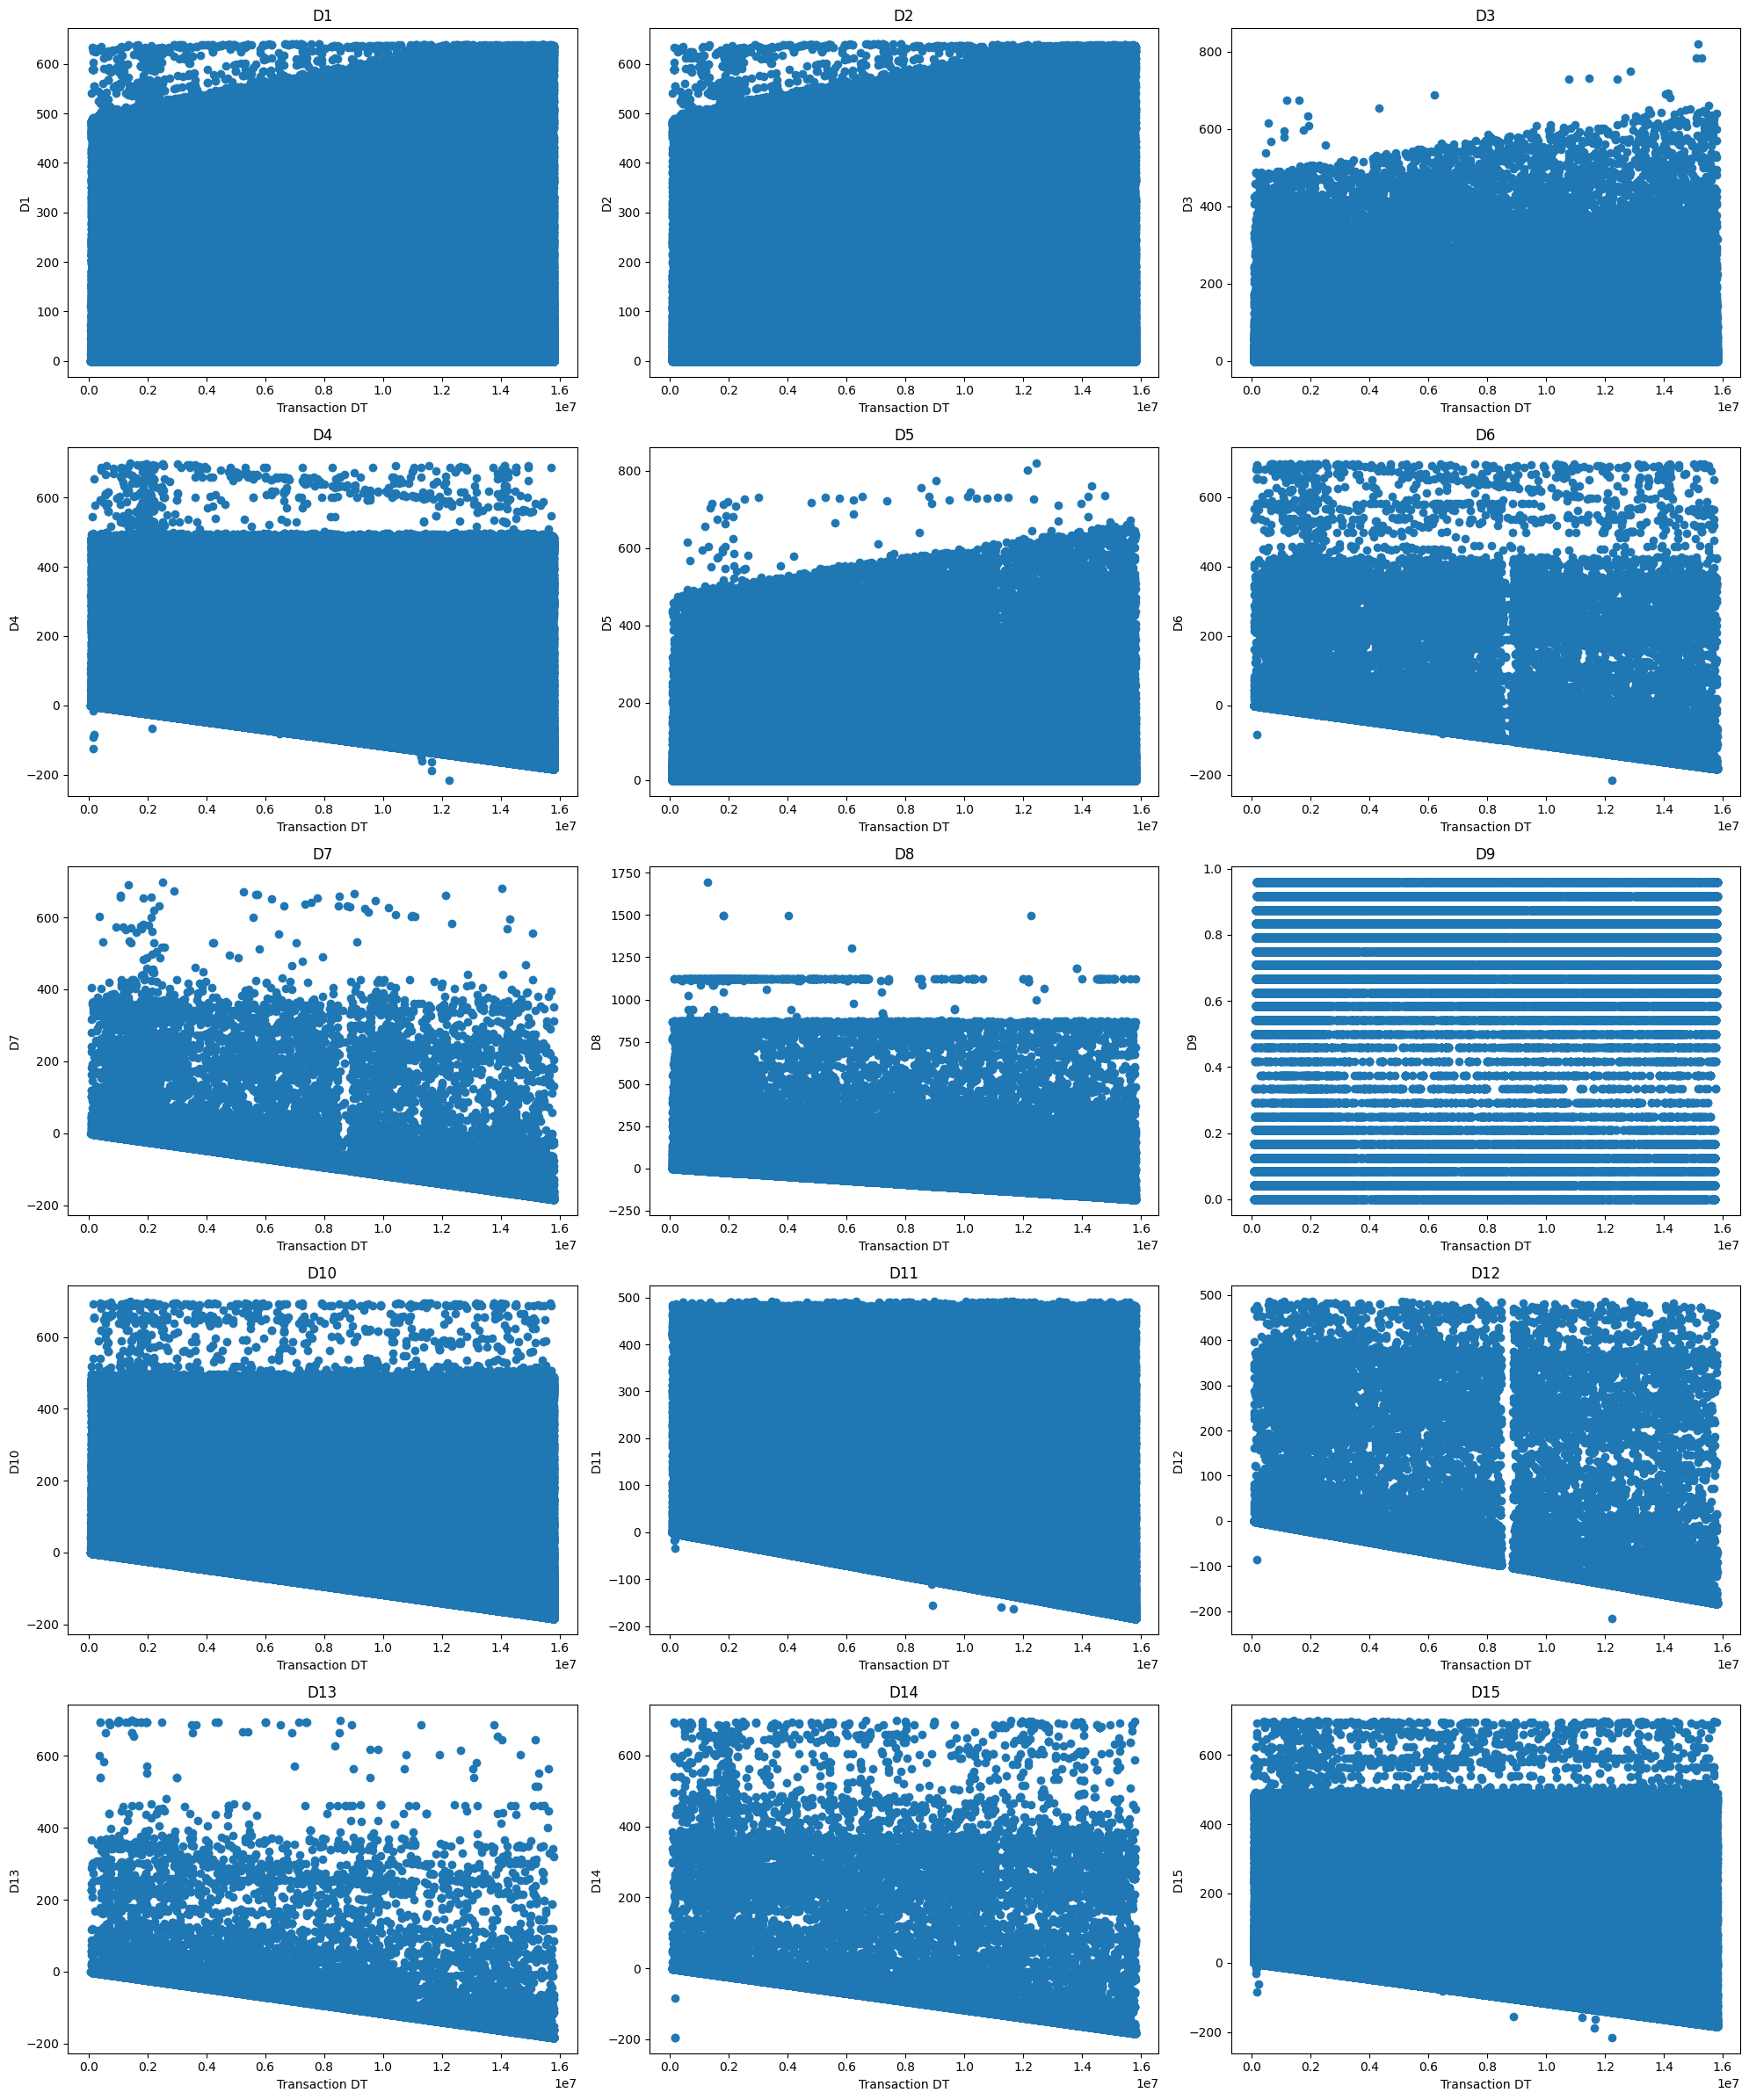

In [79]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    train['D'+str(i)] =  train['D'+str(i)] - train.TransactionDT/np.float32(24*60*60)

plot_d_cols()


## 8. Vesta Engineered Features (Vxxx)


**Study of v features [here](https://www.kaggle.com/code/cdeotte/eda-for-columns-v-and-id) determined 219 V columns as redundant by correlation analysis**

In [80]:
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]

In [81]:
v_features = [f'V{i}' for i in v if f'V{i}' in train.columns]
v_data = train[v_features]

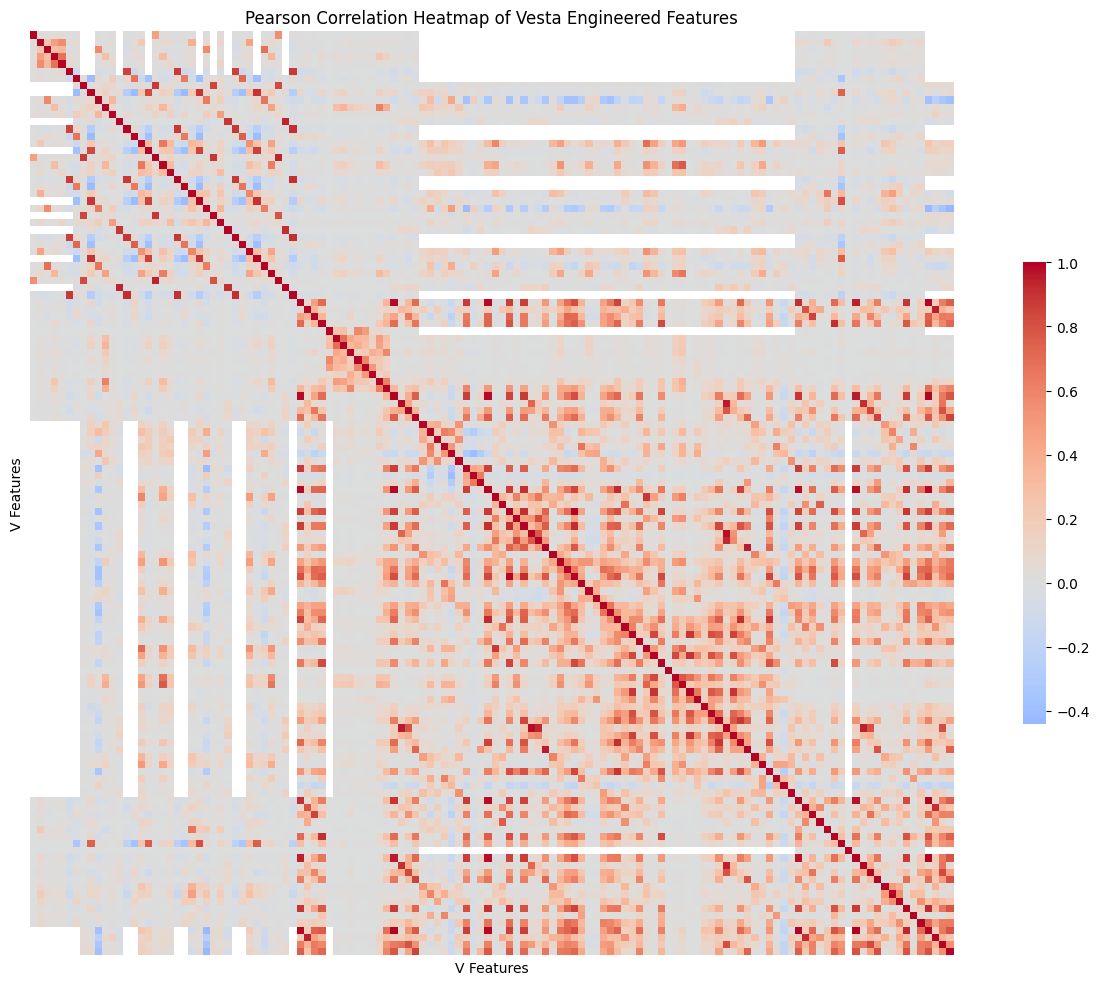

In [82]:
# Compute Pearson and Spearman correlation matrices
pearson_corr = v_data.corr(method='pearson')

# Plot Pearson correlation heatmap (show only lower triangle for clarity)
plt.figure(figsize=(18, 12))
sns.heatmap(pearson_corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': .5}, linewidths=0)
plt.title('Pearson Correlation Heatmap of Vesta Engineered Features')
plt.ylabel('V Features')
plt.xlabel('V Features')
plt.yticks([])
plt.xticks([])
plt.show()

still very correlated. Drop corr > 90%

In [86]:
v_data, colsToDrop = drop_correlated_features(v_data)

Correlation threshold: 0.9
Dropping 20 correlated features:
 • V309
 • V80
 • V180
 • V274
 • V253
 • V332
 • V307
 • V88
 • V178
 • V266
 • V296
 • V127
 • V325
 • V218
 • V297
 • V277
 • V91
 • V294
 • V89
 • V203


In [95]:
train = train.drop(columns=[x for x in train.columns if x not in v_data.columns and x.startswith("V")], axis='columns')


## 9. Identity Features


In [109]:
# ---------------------------
# Basic Overview
# ---------------------------
id_columns = [x for x in train.columns if x.startswith("id_") or x.startswith("Device")]
print("\nColumns:", id_columns)
print("\nInfo:")
train[id_columns].info()


Columns: ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_01       144233 non-null  float64
 1   id_02       140872 non-null  float64
 2   id_03       66324 non-null   float64
 3   id_04       66324 non-null   float64
 4   id_05       136865 non-null  float64
 5   id_06       136865 non-null  float64
 6   id_09       74926 non-null   float64
 7   id_10       74926 non-null   float64
 8   id_11       140978 non-null  float64
 9   id_12       144233 non-null  object 
 10  id_13       127320 non-null  float64
 11  id_14       80044 non-null   float64
 12


Missing Values (%):
 id_04         88.768923
id_03         88.768923
id_33         87.589494
id_10         87.312290
id_09         87.312290
id_30         86.865411
id_32         86.861855
id_34         86.824771
id_14         86.445626
DeviceInfo    79.905510
id_13         78.440072
id_16         78.098012
id_06         76.823755
id_05         76.823755
id_20         76.418024
id_19         76.408372
id_17         76.399736
id_31         76.245132
DeviceType    76.155722
id_02         76.145223
id_29         76.127273
id_11         76.127273
id_28         76.127273
id_36         76.126088
id_15         76.126088
id_35         76.126088
id_38         76.126088
id_37         76.126088
id_12         75.576083
id_01         75.576083
dtype: float64


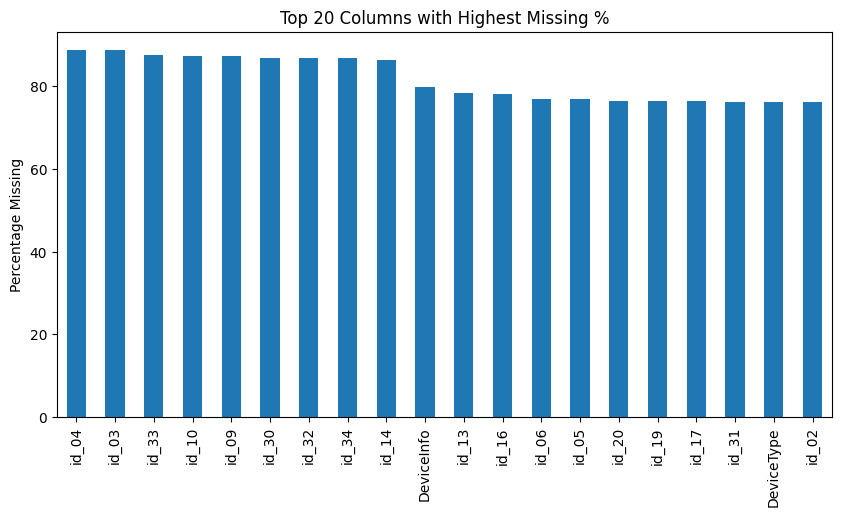

In [110]:
# ---------------------------
# Missing Values
# ---------------------------
missing = train[id_columns].isnull().mean().sort_values(ascending=False) * 100
print("\nMissing Values (%):\n", missing)

plt.figure(figsize=(10,5))
missing.head(20).plot(kind="bar")
plt.title("Top 20 Columns with Highest Missing %")
plt.ylabel("Percentage Missing")
plt.show()

In [111]:
# ---------------------------
# Descriptive Statistics
# ---------------------------
print("\nDescriptive Statistics:")
display(train[id_columns].fillna(-1).describe(include="all").transpose())


Descriptive Statistics:


count  unique  top      freq          mean            std  \
id_01       590540.0     NaN  NaN       NaN     -3.239796       8.111911   
id_02       590540.0     NaN  NaN       NaN  41677.490184  107819.841803   
id_03       590540.0     NaN  NaN       NaN     -0.880929       0.390196   
id_04       590540.0     NaN  NaN       NaN     -0.894309       0.378791   
id_05       590540.0     NaN  NaN       NaN     -0.393806       2.757834   
id_06       590540.0     NaN  NaN       NaN     -2.320747       8.295249   
id_09       590540.0     NaN  NaN       NaN     -0.861574       0.504651   
id_10       590540.0     NaN  NaN       NaN     -0.911329       1.020455   
id_11       590540.0     NaN  NaN       NaN     23.050656      42.951877   
id_12       590540.0     3.0 -1.0  446307.0           NaN            NaN   
id_13       590540.0     NaN  NaN       NaN      9.575807      20.900260   
id_14       590540.0     NaN  NaN       NaN    -47.560243     122.539171   
id_15       590540.0     4.0 -1.0  449555.0           NaN            NaN   
id_16       590540.0     3.0 -1.0  461200.0           NaN            NaN   
id_17       590540.0     NaN  NaN       NaN     43.947028      82.205527   
id_19       590540.0     NaN  NaN       NaN     82.544602     165.234397   
id_20       590540.0     NaN  NaN       NaN     94.479332     187.086941   
id_28       590540.0     3.0 -1.0  449562.0           NaN            NaN   
id_29       590540.0     3.0 -1.0  449562.0           NaN            NaN   
id_30       590540.0    76.0 -1.0  512975.0           NaN            NaN   
id_31       590540.0   131.0 -1.0  450258.0           NaN            NaN   
id_32       590540.0     NaN  NaN       NaN      2.614119       9.391106   
id_33       590540.0   261.0 -1.0  517251.0           NaN            NaN   
id_34       590540.0     5.0 -1.0  512735.0           NaN            NaN   
id_35       590540.0     3.0 -1.0  449555.0           NaN            NaN   
id_36       590540.0     3.0 -1.0  449555.0           NaN            NaN   
id_37       590540.0     3.0 -1.0  449555.0           NaN            NaN   
id_38       590540.0     3.0 -1.0  449555.0           NaN            NaN   
DeviceType  590540.0     3.0 -1.0  449730.0           NaN            NaN   
DeviceInfo  590540.0  1787.0 -1.0  471874.0           NaN            NaN   

              min  25%  50%  75%       max  
id_01      -100.0 -1.0 -1.0 -1.0       0.0  
id_02        -1.0 -1.0 -1.0 -1.0  999595.0  
id_03       -13.0 -1.0 -1.0 -1.0      10.0  
id_04       -28.0 -1.0 -1.0 -1.0       0.0  
id_05       -72.0 -1.0 -1.0 -1.0      52.0  
id_06      -100.0 -1.0 -1.0 -1.0       0.0  
id_09       -36.0 -1.0 -1.0 -1.0      25.0  
id_10      -100.0 -1.0 -1.0 -1.0       0.0  
id_11        -1.0 -1.0 -1.0 -1.0     100.0  
id_12         NaN  NaN  NaN  NaN       NaN  
id_13        -1.0 -1.0 -1.0 -1.0      64.0  
id_14      -660.0 -1.0 -1.0 -1.0     720.0  
id_15         NaN  NaN  NaN  NaN       NaN  
id_16         NaN  NaN  NaN  NaN       NaN  
id_17        -1.0 -1.0 -1.0 -1.0     229.0  
id_19        -1.0 -1.0 -1.0 -1.0     671.0  
id_20        -1.0 -1.0 -1.0 -1.0     661.0  
id_28         NaN  NaN  NaN  NaN       NaN  
id_29         NaN  NaN  NaN  NaN       NaN  
id_30         NaN  NaN  NaN  NaN       NaN  
id_31         NaN  NaN  NaN  NaN       NaN  
id_32        -1.0 -1.0 -1.0 -1.0      32.0  
id_33         NaN  NaN  NaN  NaN       NaN  
id_34         NaN  NaN  NaN  NaN       NaN  
id_35         NaN  NaN  NaN  NaN       NaN  
id_36         NaN  NaN  NaN  NaN       NaN  
id_37         NaN  NaN  NaN  NaN       NaN  
id_38         NaN  NaN  NaN  NaN       NaN  
DeviceType    NaN  NaN  NaN  NaN       NaN  
DeviceInfo    NaN  NaN  NaN  NaN       NaN

In [112]:
# ---------------------------
# Separate Numerical & Categorical Features
# ---------------------------
num_cols = train[id_columns].select_dtypes(include=["int64", "float64"]).columns
cat_cols = train[id_columns].select_dtypes(include=["object"]).columns

print(f"\nNumerical columns ({len(num_cols)}): {num_cols.tolist()}")
print(f"Categorical columns ({len(cat_cols)}): {cat_cols.tolist()}")


Numerical columns (15): ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_32']
Categorical columns (15): ['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


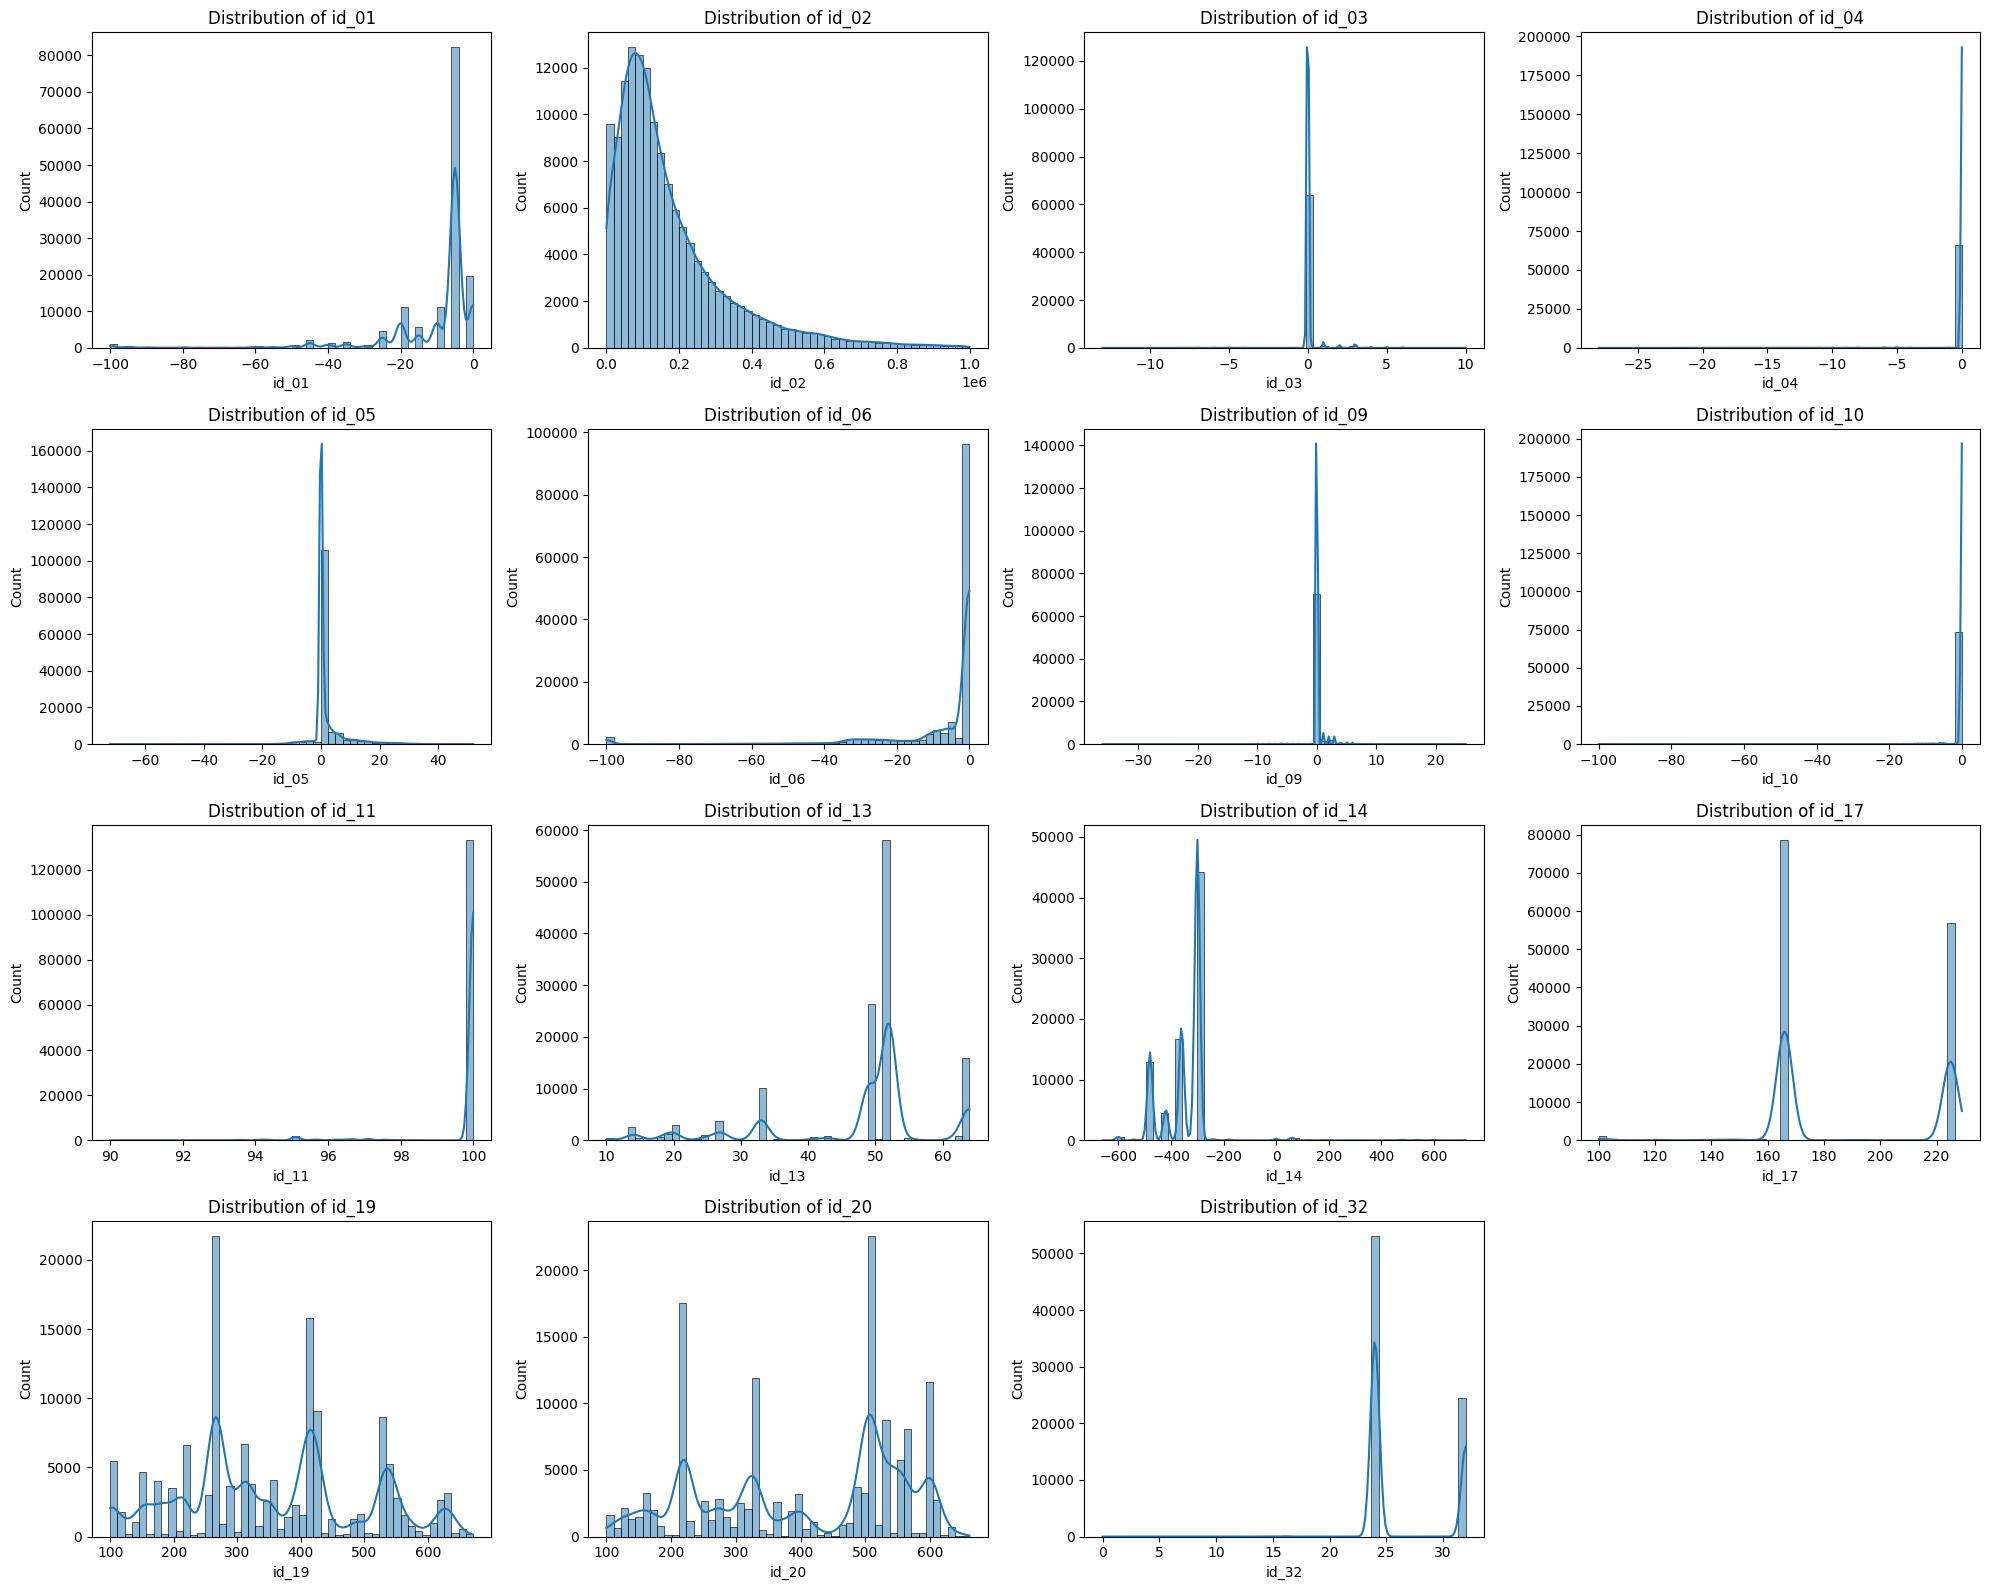

In [113]:
# ---------------------------
# Distribution Plots (Numerical) - 4 per row
# ---------------------------

n_cols = 4
n_rows = math.ceil(len(num_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(train[col].dropna(), kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

# Hide any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

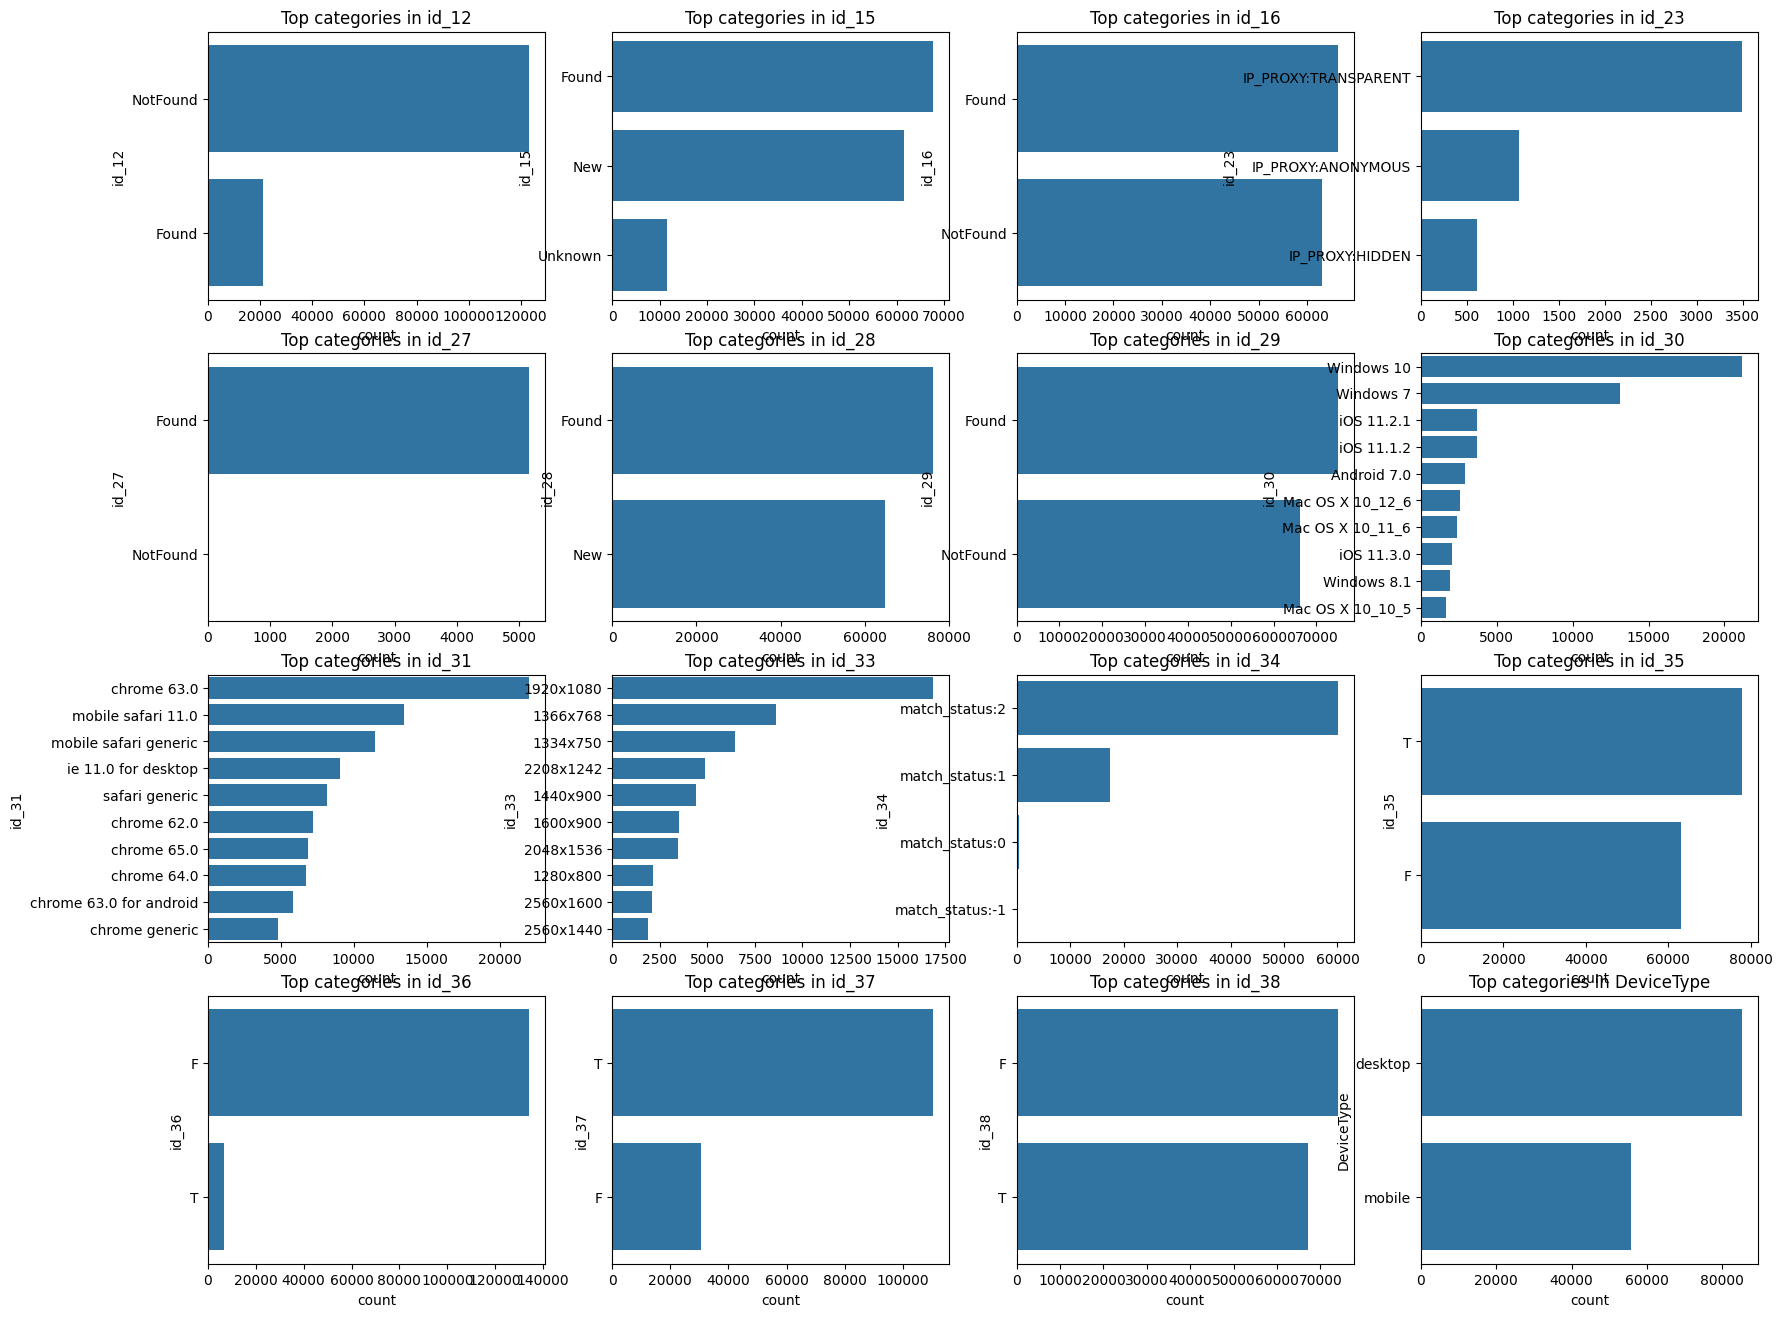

In [30]:
# ---------------------------
# Count Plots (Categorical)
# ---------------------------
n_cols = 4
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(y=col, data=train[id_columns], order=train[id_columns][col].value_counts().index[:10], ax=axes[i])
    axes[i].set_title(f"Top categories in {col}")

# Remove empty subplots if any
for idx in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[idx])

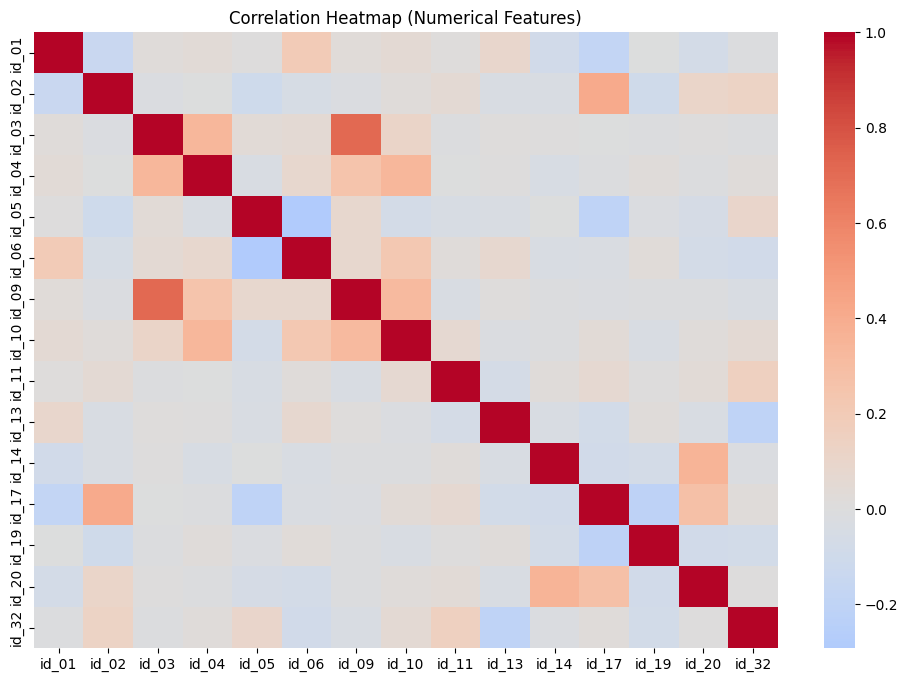

In [114]:
# ---------------------------
# Correlation Analysis
# ---------------------------
plt.figure(figsize=(12,8))
sns.heatmap(train[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

# Preprocessing

## 1. Functions Used

In [115]:
def encode_AG_numeric(main_columns, agg_cols, train_df=None, fillna=True, usena=False):
    """
    Efficiently create group-based statistical features
    and relative-difference-from-mean features.

    Example:
        For each group of agg_cols, compute mean(A), std(A),
        and (A - mean(A)) / std(A) for rows in that group.
    """
    for main_col in main_columns:
        mean_col_name = f"{'_'.join(agg_cols)}_{main_col}_mean"
        std_col_name = f"{'_'.join(agg_cols)}_{main_col}_std"
        rel_col = f"{'_'.join(agg_cols)}_{main_col}_rel"

        print(f"Computing MEAN/STD of {main_col} grouped by {agg_cols} ...")

        tmp = train_df[agg_cols + [main_col]]
        if usena:
            tmp.loc[tmp[main_col] == -1, main_col] = np.nan

        mean_map = tmp.groupby(agg_cols, as_index=False)[main_col].mean().rename(columns={main_col: mean_col_name})
        std_map = tmp.groupby(agg_cols, as_index=False)[main_col].std().fillna(0).rename(columns={main_col: std_col_name})

        train_df = train_df.merge(mean_map, on=agg_cols, how='left')
        train_df = train_df.merge(std_map, on=agg_cols, how='left')
        if fillna:
            train_df[mean_col_name].fillna(-1, inplace=True)
            train_df[std_col_name].fillna(-1, inplace=True)
        # Relative deviation feature
        train_df[rel_col] = ((train_df[main_col] - train_df[mean_col_name]) /
                             train_df[std_col_name].replace(0, np.nan)).astype('float32')
        print(f"   → Added '{mean_col_name}', '{std_col_name}', and '{rel_col}'")
    return train_df

In [116]:
# group aggregation for categorical features
def encode_AG_cat(main_columns, uids, train_df=train):
    """
    Efficiently encode user-based aggregation features:
    - *_ct  : number of distinct main_column values per UID (behavioral diversity)
    - *_freq: frequency of each main_column value within UID (contextual typicality)

    Parameters
    ----------
    main_columns : list[str]
        Feature names whose diversity/frequency we want to compute (e.g., ['card1', 'P_emaildomain'])
    uids : list[str]
        UID-like columns to group by (e.g., ['uid', 'uid2', 'uid3'])
    train_df : pd.DataFrame
        Training dataframe
    test_df : pd.DataFrame
        Test dataframe (used for consistent mapping)
    """
    for main_col in main_columns:
        for uid in uids:
            print(f"Encoding features for pair: ({uid}, {main_col}) ...")

            # Combine train+test for consistent mappings
            comb = train_df[[uid, main_col]]

            # ---- Diversity (unique count per UID) ----
            diversity = comb.groupby(uid)[main_col].nunique().rename(f"{uid}_{main_col}_ct").astype('float32').reset_index()

            # ---- Frequency (count of each value per UID) ----
            freq = comb.groupby([uid, main_col]).size().rename(f"{uid}_{main_col}_freq").astype('float32').reset_index()

            # Merge diversity into train/test
            train_df = train_df.merge(diversity, on=uid, how='left')

            # Merge frequency into train/test
            train_df = train_df.merge(freq, on=[uid, main_col], how='left')

            print(f"   → Added: {uid}_{main_col}_ct and {uid}_{main_col}_freq")

    return train_df

In [117]:
def plot_fraud_vs_relative_feature(train, target, feature):
    """
    Plot fraud percentage against a relative feature with quantile binning.
    Parameters
    ----------
    train : pd.DataFrame
        Training dataframe containing the relative feature.
    target : pd.Series
        Target variable (isFraud).
    """
    # Bin the continuous feature to get stable fraud-rate estimates
    num_bins = 10
    bins = pd.qcut(train[feature], q=num_bins, duplicates='drop')
    fraud_rate_by_bin = pd.concat([train,target],axis=1).groupby(bins, observed=True)['isFraud'].mean()
    counts_by_bin = pd.concat([train,target],axis=1).groupby(bins, observed=True)['isFraud'].size()

    # Midpoints for plotting on x-axis
    bin_midpoints = bins.apply(lambda x: 0.5 * (x.left + x.right))

    # Compute x for each bin as its midpoint
    x_by_bin = bin_midpoints.groupby(bins, observed=True).first()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Fraud rate line (percentage)
    ax1.plot(x_by_bin.values, (fraud_rate_by_bin.values * 100), marker='o', color='tab:red', label='Fraud %')
    ax1.set_xlabel(f'{feature} (binned midpoints)')
    ax1.set_ylabel('Fraud percentage (%)', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Secondary axis: counts to show support per bin
    ax2 = ax1.twinx()
    ax2.bar(x_by_bin.values, counts_by_bin.values, width=(x_by_bin.values[1]-x_by_bin.values[0]) if len(x_by_bin.values) > 1 else 0.1,
            alpha=0.2, color='tab:blue', label='Count')
    ax2.set_ylabel('Count', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'Fraud percentage vs {feature} (quantile-binned)')
    fig.tight_layout()
    plt.show()

In [118]:
def plot_fraud_vs_frequency_feature(train, target, feature):
    """
    Plot fraud percentage vs a frequency (count) feature using fixed bins (0–25%, 25–50%, etc).

    Parameters
    ----------
    train : pd.DataFrame
        Training dataframe containing the frequency feature.
    target : pd.Series
        Target variable (isFraud).
    feature : str
        Name of the frequency feature to plot (should be numerical).
    """
    # Binning into percentiles: 0–25%, 25–50%, 50–75%, 75–100%
    bins = [0.0, 0.25, 0.5, 0.75, 1.0]
    # Compute quantile edges
    quantile_edges = train[feature].quantile(bins).values
    # Ensure bins are unique/increasing; sometimes quantiles collapse on identical values
    quantile_edges = sorted(set(quantile_edges))
    # If not enough unique bins, fall back to pd.cut and signal
    if len(quantile_edges) < 3:
        cut_bins = 4
        bin_labels = ['0-25%', '25-50%', '50-75%', '75-100%']
        bin_indices = pd.cut(train[feature], bins=cut_bins, labels=bin_labels, include_lowest=True)
    else:
        bin_labels = [f"{int(bins[i]*100)}-{int(bins[i+1]*100)}%" for i in range(len(quantile_edges)-1)]
        bin_indices = pd.cut(train[feature], bins=quantile_edges, labels=bin_labels, include_lowest=True)

    fraud_rate_by_bin = pd.concat([bin_indices, target], axis=1).groupby(feature)[target.name].mean()
    counts_by_bin = pd.concat([bin_indices, target], axis=1).groupby(feature)[target.name].size()
    # For plotting, index by bin label order
    sorted_bin_labels = bin_labels
    fraud_rate_plot = fraud_rate_by_bin.reindex(sorted_bin_labels)
    counts_plot = counts_by_bin.reindex(sorted_bin_labels)

    fig, ax1 = plt.subplots(figsize=(12, 6))
    # Fraud rate plot
    ax1.plot(sorted_bin_labels, fraud_rate_plot.values*100, marker='o', color='tab:red', label='Fraud %')
    ax1.set_xlabel(f'{feature} frequency bins')
    ax1.set_ylabel('Fraud percentage (%)', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    # Counts plot
    ax2 = ax1.twinx()
    ax2.bar(sorted_bin_labels, counts_plot.values, alpha=0.2, color='tab:blue', label='Count')
    ax2.set_ylabel('Count', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    plt.title(f'Fraud percentage vs {feature} (frequency bins)')
    fig.tight_layout()
    plt.show()

## 2. User ID feature

In [120]:
train['uid'] = train['card1'].astype(str)+'_'+train['addr1'].astype(str)+'_'+np.floor(train['TransactionDay']-train['D1']).astype(str)

In [123]:
# get transaction dt interval for each uid 
train["original_index"] = train.index

# 3. Sort
sorted = train.sort_values(["uid", "TransactionDT"])

# 4. Compute feature
sorted["time_since_prev"] = sorted.groupby("uid")["TransactionDT"].diff()

# 5. Split back
train = sorted.sort_values("original_index").drop(columns=["original_index"])

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=train, x="isFraud", y="time_since_prev")
plt.title("Time Since Previous Transaction vs isFraud (Boxplot)")
plt.xlabel("isFraud")
plt.ylabel("time_since_prev")
plt.show()

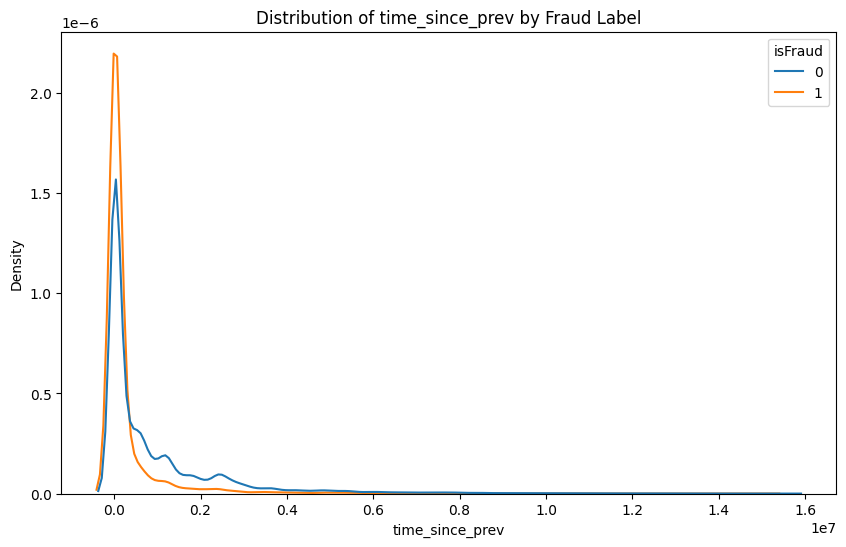

In [130]:
# ------- KDE / Distribution Plot -------
plt.figure(figsize=(10,6))
sns.kdeplot(data=train, x="time_since_prev", hue="isFraud", common_norm=False)
plt.title("Distribution of time_since_prev by Fraud Label")
plt.xlabel("time_since_prev")
plt.show()

In [157]:
fraud_users = (
    train.groupby("uid")
         .agg(
             has_fraud = ("isFraud", "max"),      # 1 if any fraud exists
             transaction_count = ("TransactionID", "count"),
             fraud_count = ("isFraud","sum")
         )
         .query("has_fraud == 1")                 # keep only users with fraud
         .sort_values("transaction_count")
)

In [ ]:
non_fraud_users = (
    train.groupby("uid")
         .agg(
             has_fraud = ("isFraud", "max"),      # 1 if any fraud exists
             transaction_count = ("TransactionID", "count"),
             fraud_count = ("isFraud","sum")
         )
         .query("has_fraud == 0")                 # keep only users with fraud
         .sort_values("transaction_count")
)

In [186]:
fraud_users[fraud_users['fraud_count']>1].sort_values('fraud_count', ascending=False)

has_fraud  transaction_count  fraud_count
uid                                                          
12695_325.0_-342.0          1                123           90
17188_122.0_-139.0          1                 84           84
13623_498.0_117.0           1                 80           80
9002_272.0_-92.0            1                 78           78
2939_204.0_-137.0           1                 76           76
...                       ...                ...          ...
9300_nan_-344.0             1                  2            2
16075_204.0_148.0           1                  2            2
16075_177.0_49.0            1                  2            2
10054_nan_131.0             1                  2            2
9938_nan_165.0              1                  2            2

[3574 rows x 3 columns]

In [174]:
non_fraud_users['transaction_count'].value_counts()

transaction_count
1       122208
2        34723
3        16134
4         9512
5         6347
         ...  
196          1
215          1
232          1
446          1
1414         1
Name: count, Length: 104, dtype: int64

In [ ]:
train[train['uid']=='15775_330.0_129.0']

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
441022        3428022       11204367           100.0         S  15775  481.0   
468679        3455679       12081968            10.0         S  15775  481.0   
478818        3465818       12426792            55.0         S  15775  481.0   
483150        3470150       12577656            75.0         S  15775  481.0   
486244        3473244       12673229            65.0         S  15775  481.0   
...               ...            ...             ...       ...    ...    ...   
574505        3561505       15271575            30.0         S  15775  481.0   
577530        3564530       15364252           120.0         S  15775  481.0   
579667        3566667       15451381            85.0         S  15775  481.0   
581436        3568436       15527523            30.0         S  15775  481.0   
586575        3573575       15701201           120.0         S  15775  481.0   

        card3       card4  card5   card6  ...  cents                uid  \
441022  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   
468679  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   
478818  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   
483150  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   
486244  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   
...       ...         ...    ...     ...  ...    ...                ...   
574505  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   
577530  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   
579667  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   
581436  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   
586575  150.0  mastercard  102.0  credit  ...      0  15775_330.0_129.0   

        time_since_prev isFraud P_emaildomain_1  P_emaildomain_2  \
441022              NaN       0             NaN              NaN   
468679         877601.0       0             NaN              NaN   
478818         344824.0       0             NaN              NaN   
483150         150864.0       0             NaN              NaN   
486244          95573.0       0             NaN              NaN   
...                 ...     ...             ...              ...   
574505          96820.0       0             NaN              NaN   
577530          92677.0       0             NaN              NaN   
579667          87129.0       0             NaN              NaN   
581436          76142.0       0             NaN              NaN   
586575         173678.0       0             NaN              NaN   

        P_emaildomain_3  R_emaildomain_1  R_emaildomain_2  R_emaildomain_3  
441022              NaN            yahoo              com             None  
468679              NaN            yahoo              com             None  
478818              NaN            yahoo              com             None  
483150              NaN            yahoo              com             None  
486244              NaN            yahoo              com             None  
...                 ...              ...              ...              ...  
574505              NaN            yahoo              com             None  
577530              NaN            yahoo              com             None  
579667              NaN            yahoo              com             None  
581436              NaN            yahoo              com             None  
586575              NaN            yahoo              com             None  

[1414 rows x 194 columns]

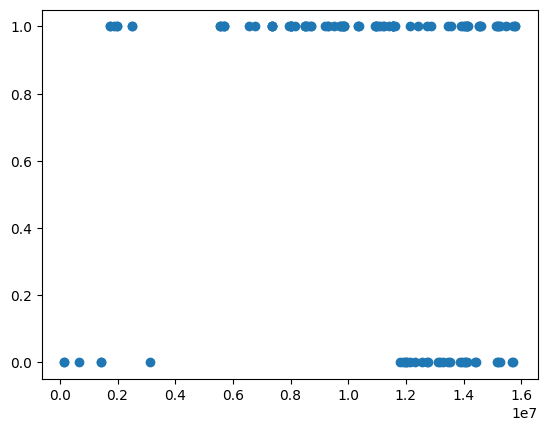

In [184]:
plt.scatter(data=train[train['uid']=='12695_325.0_-342.0'], x='TransactionDT', y='isFraud')
plt.show()

## 5. Aggregations and groupings

In [126]:
#split email domains
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)

In [187]:
num_cols = np.array(train.select_dtypes(exclude=['object','category']).columns)
num_cols

array(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'C1', 'C3',
       'C5', 'C13', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10',
       'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V3', 'V4', 'V6', 'V8',
       'V11', 'V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30',
       'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56',
       'V59', 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V82',
       'V86', 'V96', 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115',
       'V117', 'V120', 'V121', 'V123', 'V124', 'V129', 'V130', 'V136',
       'V138', 'V139', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165',
       'V166', 'V169', 'V171', 'V173', 'V175', 'V176', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V205', 'V207', 'V209', 'V210', 'V215',
       'V220', 'V221', 'V223', 'V224', 'V226', 'V228', 'V229', 'V234',
       'V235', 'V238', 'V240', 'V250', 'V252', 'V257', 'V258', 'V260',
 

In [188]:
cat_cols = np.array(train.select_dtypes(include=['object','category']).columns)
cat_cols

array(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
       'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12',
       'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo', 'uid', 'P_emaildomain_1', 'P_emaildomain_2',
       'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2',
       'R_emaildomain_3'], dtype=object)

In [190]:
train = encode_AG_numeric(['TransactionAmt'], ['card1'], train_df=train)

Computing MEAN/STD of TransactionAmt grouped by ['card1'] ...
   → Added 'card1_TransactionAmt_mean', 'card1_TransactionAmt_std', and 'card1_TransactionAmt_rel'


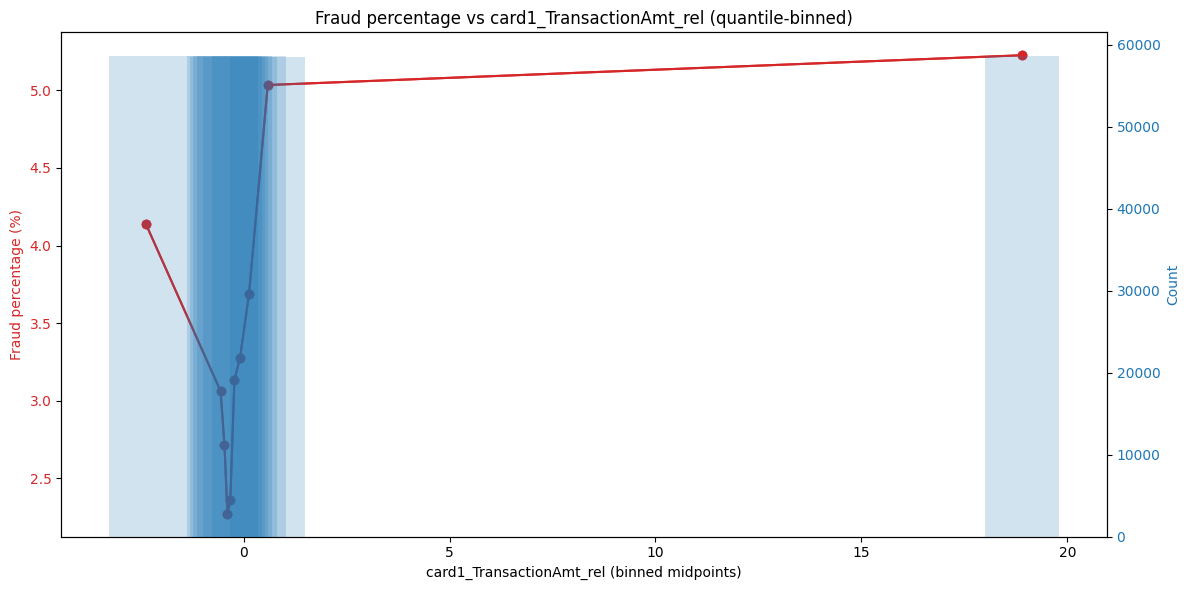

In [191]:
plot_fraud_vs_relative_feature(train, train['isFraud'], 'card1_TransactionAmt_rel')

In [192]:
train = encode_AG_numeric(['TransactionAmt'], ['card4'], train_df=train)

Computing MEAN/STD of TransactionAmt grouped by ['card4'] ...
   → Added 'card4_TransactionAmt_mean', 'card4_TransactionAmt_std', and 'card4_TransactionAmt_rel'


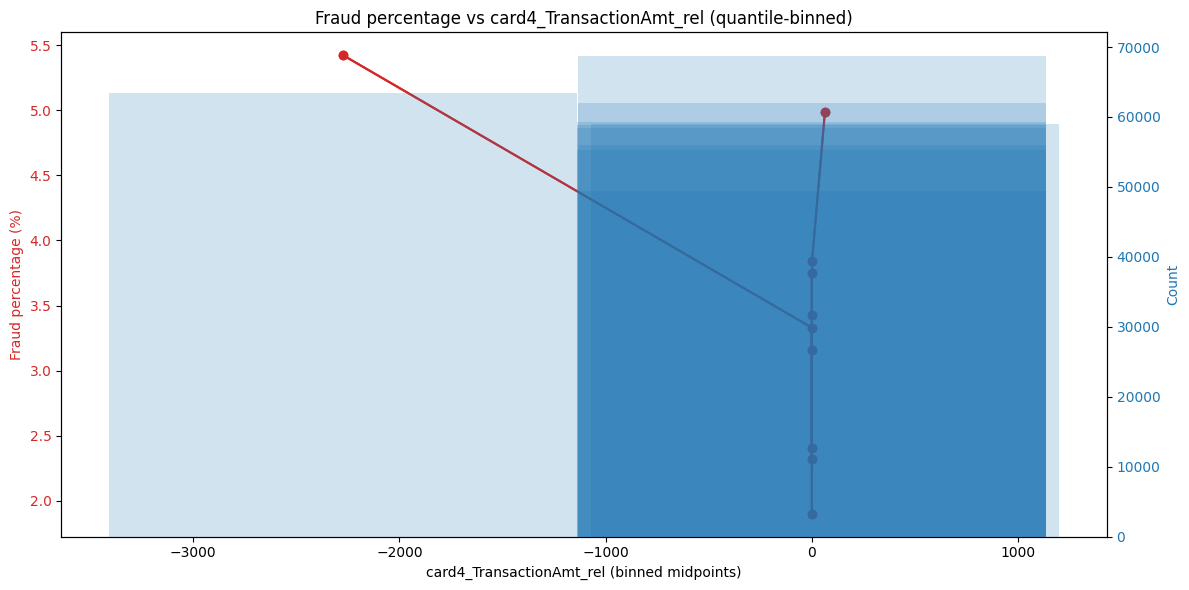

In [193]:
plot_fraud_vs_relative_feature(train, train['isFraud'], 'card4_TransactionAmt_rel')

In [194]:
train = encode_AG_numeric(['TransactionAmt'], ['card6'], train_df=train)

Computing MEAN/STD of TransactionAmt grouped by ['card6'] ...
   → Added 'card6_TransactionAmt_mean', 'card6_TransactionAmt_std', and 'card6_TransactionAmt_rel'


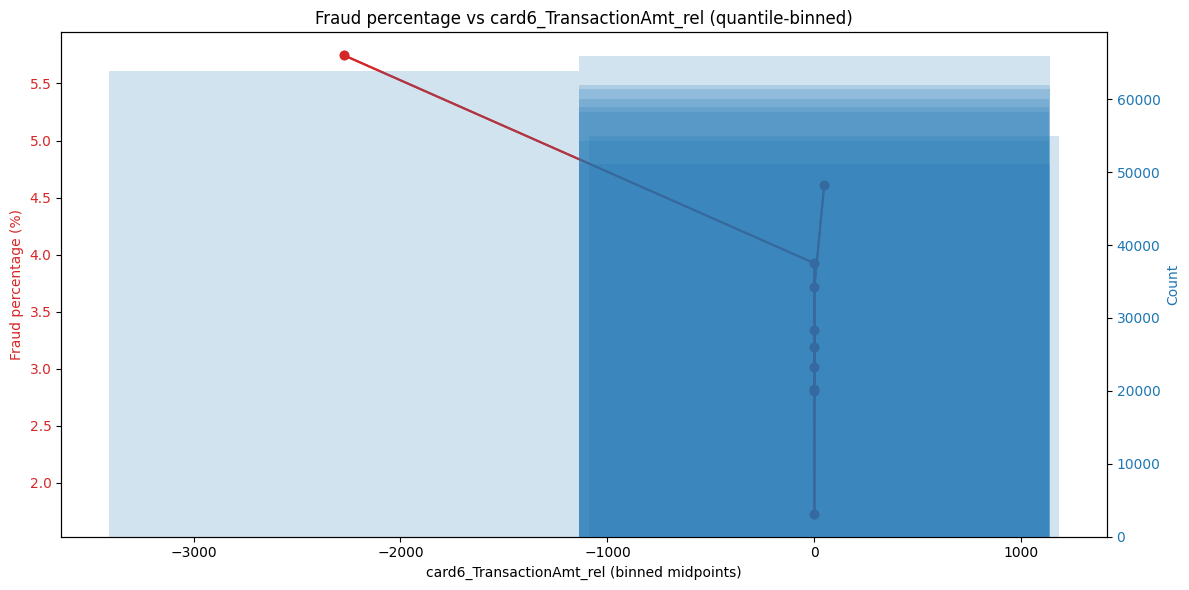

In [195]:
plot_fraud_vs_relative_feature(train, train['isFraud'], 'card6_TransactionAmt_rel')

In [196]:
train = encode_AG_numeric(['TransactionAmt'], ['ProductCD'], train_df=train)

Computing MEAN/STD of TransactionAmt grouped by ['ProductCD'] ...
   → Added 'ProductCD_TransactionAmt_mean', 'ProductCD_TransactionAmt_std', and 'ProductCD_TransactionAmt_rel'


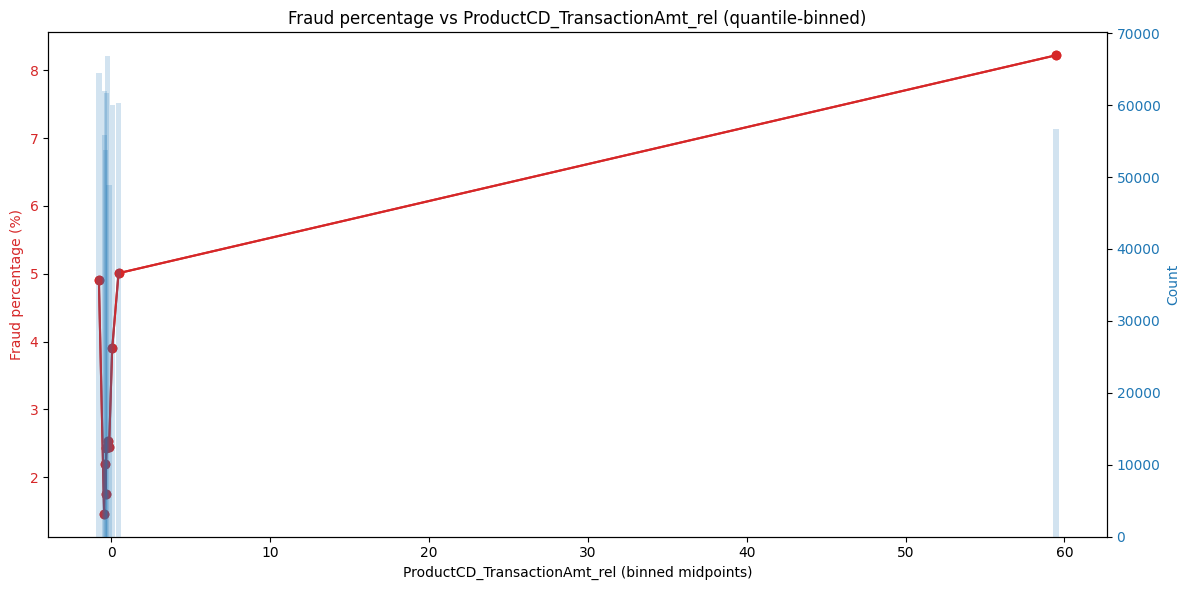

In [201]:
plot_fraud_vs_relative_feature(train, train['isFraud'], 'ProductCD_TransactionAmt_rel')

In [202]:
train = encode_AG_numeric(['TransactionAmt'],['uid','day_of_week'],train_df=train)

Computing MEAN/STD of TransactionAmt grouped by ['uid', 'day_of_week'] ...
   → Added 'uid_day_of_week_TransactionAmt_mean', 'uid_day_of_week_TransactionAmt_std', and 'uid_day_of_week_TransactionAmt_rel'


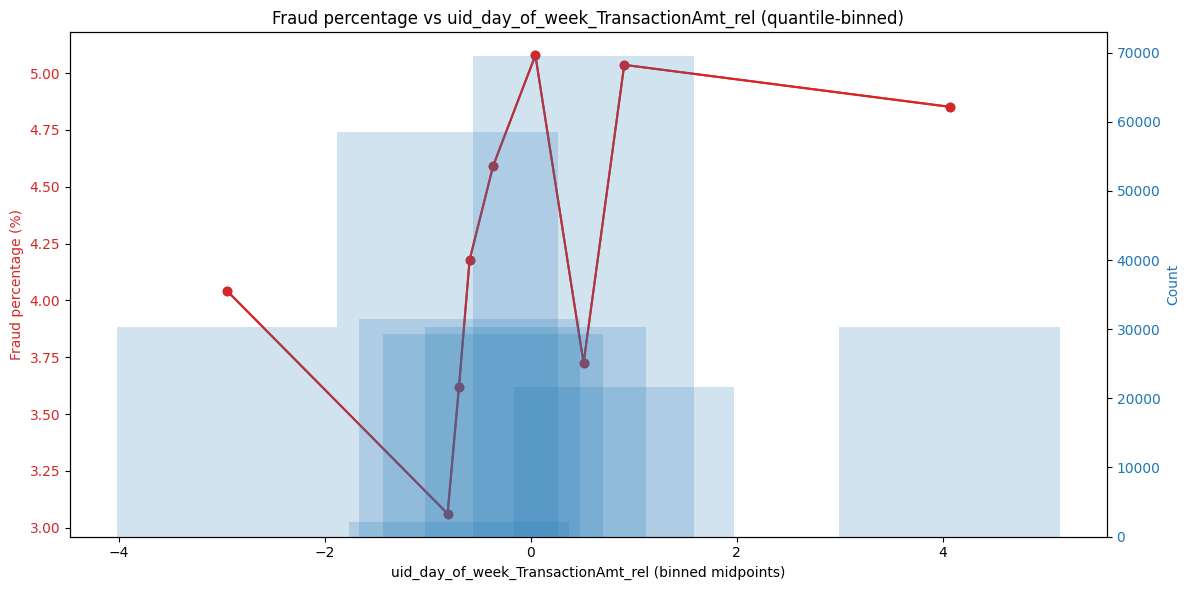

In [203]:
plot_fraud_vs_relative_feature(train, train['isFraud'], 'uid_day_of_week_TransactionAmt_rel')

In [199]:
train = encode_AG_numeric(['TransactionAmt'],['uid','hour_of_day'],train_df=train)

Computing MEAN/STD of TransactionAmt grouped by ['uid', 'hour_of_day'] ...
   → Added 'uid_hour_of_day_TransactionAmt_mean', 'uid_hour_of_day_TransactionAmt_std', and 'uid_hour_of_day_TransactionAmt_rel'


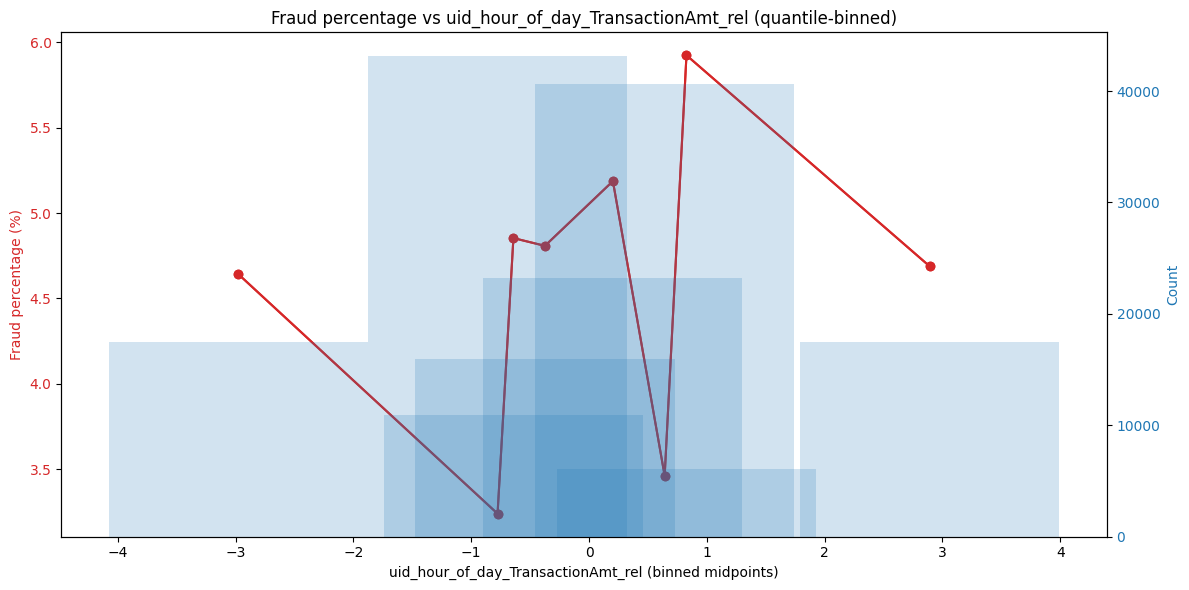

In [204]:
plot_fraud_vs_relative_feature(train, train['isFraud'], 'uid_hour_of_day_TransactionAmt_rel')

In [205]:
train = encode_AG_numeric(['id_02','D15'], ['card1'], train_df=train)
train = encode_AG_numeric(['id_02','D15'], ['card4'], train_df=train)
train = encode_AG_numeric(['D15'], ['addr1'], train_df=train)
train = encode_AG_numeric(['D15'], ['addr2'], train_df=train)

Computing MEAN/STD of id_02 grouped by ['card1'] ...
   → Added 'card1_id_02_mean', 'card1_id_02_std', and 'card1_id_02_rel'
Computing MEAN/STD of D15 grouped by ['card1'] ...
   → Added 'card1_D15_mean', 'card1_D15_std', and 'card1_D15_rel'
Computing MEAN/STD of id_02 grouped by ['card4'] ...
   → Added 'card4_id_02_mean', 'card4_id_02_std', and 'card4_id_02_rel'
Computing MEAN/STD of D15 grouped by ['card4'] ...
   → Added 'card4_D15_mean', 'card4_D15_std', and 'card4_D15_rel'
Computing MEAN/STD of D15 grouped by ['addr1'] ...
   → Added 'addr1_D15_mean', 'addr1_D15_std', and 'addr1_D15_rel'
Computing MEAN/STD of D15 grouped by ['addr2'] ...
   → Added 'addr2_D15_mean', 'addr2_D15_std', and 'addr2_D15_rel'


In [206]:
num_cols_list = num_cols.tolist()

In [207]:
num_cols_list.remove('TransactionID')
num_cols_list.remove('TransactionDT')
num_cols_list.remove('TransactionDay')
num_cols_list.remove('isFraud')
# remove cols used to create uid
num_cols_list.remove('addr1')
num_cols_list.remove('card1')
num_cols_list.remove('D1')

In [211]:
train = encode_AG_numeric(num_cols_list,['uid'],train_df=train)

Computing MEAN/STD of TransactionAmt grouped by ['uid'] ...
   → Added 'uid_TransactionAmt_mean', 'uid_TransactionAmt_std', and 'uid_TransactionAmt_rel'
Computing MEAN/STD of card2 grouped by ['uid'] ...
   → Added 'uid_card2_mean', 'uid_card2_std', and 'uid_card2_rel'
Computing MEAN/STD of card3 grouped by ['uid'] ...
   → Added 'uid_card3_mean', 'uid_card3_std', and 'uid_card3_rel'
Computing MEAN/STD of card5 grouped by ['uid'] ...
   → Added 'uid_card5_mean', 'uid_card5_std', and 'uid_card5_rel'
Computing MEAN/STD of addr2 grouped by ['uid'] ...
   → Added 'uid_addr2_mean', 'uid_addr2_std', and 'uid_addr2_rel'
Computing MEAN/STD of dist1 grouped by ['uid'] ...
   → Added 'uid_dist1_mean', 'uid_dist1_std', and 'uid_dist1_rel'
Computing MEAN/STD of C1 grouped by ['uid'] ...
   → Added 'uid_C1_mean', 'uid_C1_std', and 'uid_C1_rel'
Computing MEAN/STD of C3 grouped by ['uid'] ...
   → Added 'uid_C3_mean', 'uid_C3_std', and 'uid_C3_rel'
Computing MEAN/STD of C5 grouped by ['uid'] ...
   →

In [213]:
train = encode_AG_cat([x for x in cat_cols if x != 'uid'], uids=['uid'], train_df=train)

Encoding features for pair: (uid, ProductCD) ...
   → Added: uid_ProductCD_ct and uid_ProductCD_freq
Encoding features for pair: (uid, card4) ...
   → Added: uid_card4_ct and uid_card4_freq
Encoding features for pair: (uid, card6) ...
   → Added: uid_card6_ct and uid_card6_freq
Encoding features for pair: (uid, P_emaildomain) ...
   → Added: uid_P_emaildomain_ct and uid_P_emaildomain_freq
Encoding features for pair: (uid, R_emaildomain) ...
   → Added: uid_R_emaildomain_ct and uid_R_emaildomain_freq
Encoding features for pair: (uid, M1) ...
   → Added: uid_M1_ct and uid_M1_freq
Encoding features for pair: (uid, M2) ...
   → Added: uid_M2_ct and uid_M2_freq
Encoding features for pair: (uid, M3) ...
   → Added: uid_M3_ct and uid_M3_freq
Encoding features for pair: (uid, M4) ...
   → Added: uid_M4_ct and uid_M4_freq
Encoding features for pair: (uid, M5) ...
   → Added: uid_M5_ct and uid_M5_freq
Encoding features for pair: (uid, M6) ...
   → Added: uid_M6_ct and uid_M6_freq
Encoding featur

We keep categorical features: `day of week` and `hour of day` that we generated in EDA no reason for transaction day

In [214]:
# drop transaction dt, keep day and hour features
train.drop(['TransactionDay'], axis=1, inplace=True)

In [215]:
train.drop(['TransactionID'], axis=1, inplace=True)

In [222]:
for c in cat_cols:
    if c in train.columns:
        if train[c].isnull().sum()>0:
            train[c].fillna('missing', inplace=True)
        train[c] = train[c].astype('category')

In [223]:
print(f"Final set of features, contains {len(train.columns)} features")

Final set of features, contains 751 features


In [224]:
train.to_csv(data_folder + 'processed/train_processed.csv', index=False)

In [225]:
train.shape

(590540, 751)